In [40]:
!pip install openai
!pip install pyvis
!pip install plotly
!pip install python-dotenv
!pip install tqdm

In [1]:
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import re
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
from itertools import permutations, combinations
import json

import networkx as nx
from pyvis.network import Network

import os
from dotenv import load_dotenv, find_dotenv
import random

In [2]:
_ = load_dotenv(find_dotenv())

# api_key  = os.getenv('PIQUE_OPENAI_API_KEY')
# organization = os.getenv('PIQUE_SUPSI_ORGANIZATION')

api_key  = os.getenv('IDSIA_OPENAI_API_KEY')
organization = os.getenv('IDSIA_ORGANIZATION')

openai.api_key = api_key
openai.organization = organization

In [3]:
models = openai.Model.list()

model_ids = [model['id'] for model in models['data']]

gpt_4 = 'gpt-4'
default_model = 'gpt-3.5-turbo'
use_gpt_4 = True
if use_gpt_4 and gpt_4 in model_ids:
    default_model = gpt_4

default_model


'gpt-4'

In [4]:
def gpt_request(system_msg, user_msg, model=default_model, temperature=0.3):
    if not system_msg or not user_msg:
        return None
    try:
        response = openai.ChatCompletion.create(model=model,
                                            messages=[
                                                {"role": "system", "content": system_msg},
                                                {"role": "user", "content": user_msg}], 
                                            temperature=temperature)
        return response.choices[0].message.content
    except:
        return None

In [5]:
def gpt_ner(text):
    system_msg = 'You are a helpful assistant for Named Entity Recognition of medical texts.' 
        
    user_msg = f'''
    You will be provided with an abstract of a medical research paper delimited by the <Text></Text> xml tags. 
    Please read the provided abstract carefully to comprehend the context and content. Analyze the provided text 
    and identify all the meaningful entities that could contribute to understanding cause-and-effect relationships 
    between factors such as diseases, medications, treatments, interventions, symptoms, outcomes, effects, or risk factors. 

    Avoid including entities that are synonyms or can be used interchangeably to already identified ones. For example, if text contains 
    both "hospital" and "medical center" (which are synonyms and can be used interchangeably) and you already extracted "hospital" as final entity, 
    do not include "medical center" as well.
    
    Your response should highlight entities that are crucial for establishing causal relationships in the medical context.

    Answer listing only the found entities within the tags <Answer><Entity>[entity1]</Entity><Entity>[entity2]</Entity></Answer> 
    (e.g., <Answer><Entity>diabetes</Entity><Entity>hypertension</Entity></Answer>).)
    
    Text:
    <Text>{text}</Text>
    '''
    
    response = gpt_request(system_msg, user_msg)
    if not response:
        return []
    
    answer_text = response
    
    soup = BeautifulSoup(answer_text, 'html.parser')
    entities = [entity.text for entity in soup.find_all('entity')]
    
    return entities

In [113]:
def pick_random_causal_verb():
    verbs = ['provokes', 'triggers', 'causes', 'leads to', 'induces', 'results in', 'generates', 'produces', 'stimulates', 'instigates', 'engenders', 'promotes', 'gives rise to', 'sparks']
    # return 'causes'
    return random.choice(verbs)

In [7]:
def gpt_causal_discovery(entities, text=None, use_pretrained_knowledge=False, reverse_variable_check=False, verbose=False):

    graph_edges = []    

    system_msg = 'You are a helpful assistant for causal reasoning and cause-and-effect relationship discovery.'
 
    intro_msg = f'''
You will be provided with {"an abstract of a medical research paper delimited by the <Text></Text> xml tags, and " if text else ""}\
a pair of entities delimited by the <Entity></Entity> xml tags representing medical entities {"extracted from the given abstract" if text else ""}, such
as medications, treatments, symptoms, diseases, outcomes, side effects, or other medical factors.
            {f"""
            Text:  
            <Text>{text}</Text>""" if text else ""}'''
    instructions_msg = f'''
{"Please read the provided abstract carefully to comprehend the context and content." if text else ""}
Examine the roles, interactions, and details surrounding the entities {"within the abstract" if text else ""}.
Based {"only " if text and not use_pretrained_knowledge else ""}on {"the information in the text " if text else ""}{"and " if text and use_pretrained_knowledge else ""}\
{"your pretrained knowledge" if use_pretrained_knowledge or not text else ""}, determine the most likely cause-and-effect \
relationship between the entities from the following listed options (A, B, C, D):\
    '''
    option_choice_msg = f'''
Your response should accurately reflect the likely causal connection between the two entities based on the 
information {"presented in the text" if text else ""} {"and any additional knowledge" if text and use_pretrained_knowledge else ""} {"you are aware of" if use_pretrained_knowledge or not text else ""}.
If no clear causal relationship is apparent, select the appropriate option accordingly.
Then provide your final answer within the tags <Answer>[answer]</Answer>, (e.g. <Answer>C</Answer>).
    '''
    option_choice_msg = f'''
Your response should analyze the situation in a step-by-step manner, ensuring the correctness of the ultimate conclusion, which should 
accurately reflect the likely causal connection between the two entities based on the 
information {"presented in the text" if text else ""} {"and any additional knowledge" if text and use_pretrained_knowledge else ""} {"you are aware of" if use_pretrained_knowledge or not text else ""}.
If no clear causal relationship is apparent, select the appropriate option accordingly.

Then provide your final answer within the tags <Answer>[answer]</Answer>, (e.g. <Answer>C</Answer>).
'''

    total_iterations = len(list(permutations(entities, 2))) if reverse_variable_check else len(list(combinations(entities, 2)))
    progress_bar = tqdm(total=total_iterations, desc="Progress")

    for i1, e1 in enumerate(entities):
        for i2, e2 in enumerate(entities):
            if i1 == i2 or (not reverse_variable_check and i1 >= i2):
                continue

            if verbose:
                print(f'{i1} = {e1}, {i2} = {e2}') # TODO remove

            causal_verb = pick_random_causal_verb()
            options_with_random_verb = f'''
            Options:
            A: "{e1}" {causal_verb} "{e2}"; 
            B: "{e2}" {causal_verb} "{e1}"; 
            C: "{e1}" and "{e2}" are not directly causally related; 
            D: there is a common factor that is the cause for both "{e1}" and "{e2}";\
            '''

            user_msg = f'''\
            {intro_msg}

            Entities:
            <Entity>{e1}</Entity>
            <Entity>{e2}</Entity>
            \
            {instructions_msg}
            {options_with_random_verb}
            \
            {option_choice_msg}
            '''

            response = gpt_request(system_msg, user_msg)
            if response:
                graph_edges.append(((e1, e2), response))
            
                if verbose:
                    print(graph_edges[-1]) # TODO remove
                    print('----------------------------------')
            
            progress_bar.update(1)

    progress_bar.close()
    
    return graph_edges

In [8]:
forward_arrow = '->'
forward_arrow_answer = 'A'
backward_arrow = '<-'
backward_arrow_answer = 'B'
no_arrow = ' '
no_arrow_answer = 'C'
bidirectional_arrow = '<->'
bidirectional_arrow_answer = 'D'

arrows = {forward_arrow_answer:forward_arrow, backward_arrow_answer:backward_arrow, no_arrow_answer:no_arrow, bidirectional_arrow_answer:bidirectional_arrow}

In [9]:
answer_pattern = re.compile(r'^([A-Z])\.')

def get_edge_answer(text):
    soup = BeautifulSoup(text, 'html.parser')
    answer = soup.find('answer').text

    if answer in arrows:
        return arrows[answer]

    match = answer_pattern.match(answer)
    if match:
        answer = match.group(1)

    if answer in arrows:
        return arrows[answer]
    
    return None

In [10]:
def print_edges(graph_edges):
    for (e1, e2), answer in graph_edges:
        try:
            print(f'{e1} {get_edge_answer(answer)} {e2}')
        except:
            print(f'{e1} ? {e2}')

In [11]:
def optimize_entities(entities, text=None):
    system_msg = 'You are a helpful assistant for medical entity optimization, by accurately identifying synonyms, redundant entities, or entities that can be used interchangeably'

    entities_text = '\n'.join([f'<Entity>{entity}</Entity>' for entity in entities])

    user_msg = f'''
You will be provided with {'an abstract of a medical research paper delimited by the <Text></Text> xml tags, and ' if text else ''} \
a list of named entities representing medical entities, each one of them delimited by the <Entity></Entity> xml tags. \

{f"""Text:
<Text>{text}</Text>""" if text else ""}

Entities:
{entities_text}

Your task is to optimize this entity list by identifying synonyms within the entities and grouping them accordingly. 
Your goal is to create a JSON object where the keys represent the root word entities, and each key is associated with 
an array of its synonyms, i.e., words or entities that can be used interchangeably to the root word.
If a root word entity has no synonyms, its value in the JSON should be an empty array.

Ensure that each entity appears only once in the dictionary, either as key (i.e. root word) or as element in the value arrays (i.e. the synonyms):
an entity must must not appear as key if it is the synonym (i.e. in the value array) of another entity, and the other way around (i.e. must not be 
in the value array of an entity if it is already a key of the JSON object).
An entity must not be a synonym of itself.

You should efficiently process the given list of entities and produce the desired dictionary structure.
The output JSON object should accurately represent the optimized entities and their synonyms based on the provided list.

Then provide your final JSON object answer within the tags <Answer>[json_object]</Answer>, (e.g. <Answer>{{
    "smoking": ["tobacco", "nicotine", "cigarettes", "cigar"],
    "cancer": ["lung cancer"],
    "tumors": []
}}</Answer>).

Follow the example below to understand the expected output.

Example:

Given the initial list of entities:
<Entity>smoking</Entity>
<Entity>lung cancer</Entity>
<Entity>tumors</Entity>
<Entity>cancer</Entity>
<Entity>tobacco</Entity>
<Entity>nicotine</Entity>
<Entity>cigarettes</Entity>
<Entity>cigar</Entity>

You should pair the synonyms, generate the following JSON object and provide it as your answer:
<Answer>
{{
    "smoking": ["tobacco", "nicotine", "cigarettes", "cigar"],
    "cancer": ["lung cancer"],
    "tumors": []
}}
</Answer>

Note that every entity appears only once in the output JSON object, either as key or as element in the value arrays.

After you have finished building the JSON object, check and make sure that every entity appears only once in the output JSON object, either as key or as element in the value arrays.
'''

    response = gpt_request(system_msg, user_msg)
    if response:
        soup = BeautifulSoup(response, 'html.parser')
        answer = soup.find('answer').text
        try:
            opt_entities = json.loads(answer)
            if opt_entities:
                return opt_entities
        except (json.JSONDecodeError, TypeError):
            pass

    return entities

In [12]:
answer_pattern = re.compile(r'^([A-Z])[.:]')

def extract_edge_answers(edges):
    edges_with_answers = []

    for (e1, e2), text in edges:
        try:
            soup = BeautifulSoup(text, 'html.parser')
            answer = soup.find('answer').text
            
            if answer in arrows:
                edges_with_answers.append(((e1, e2), answer))
                continue

            match = answer_pattern.match(answer)
            if match:
                if match.group(1) in arrows:
                    edges_with_answers.append(((e1, e2), match.group(1)))
                    continue

        except:
            continue

    return edges_with_answers

In [13]:
def check_edge_compatibility(answer1, answer2):
    return (arrows[answer1], arrows[answer2]) in [(forward_arrow, backward_arrow), (backward_arrow, forward_arrow), (no_arrow, no_arrow), (bidirectional_arrow, bidirectional_arrow)]

def check_invalid_answers(directed_edges):
    invalid_edges = []
    valid_edges = []
    temp_edges = []
    answers = {}
    for (n1, n2), answer in directed_edges:

        if (n1, n2) not in temp_edges and (n2, n1) not in temp_edges:
            temp_edges.append((n1, n2))
            answers[(n1, n2)] = answer
        elif (n1, n2) in temp_edges:
            if answers[(n1, n2)] != answer:
                invalid_edges.append((((n1, n2), answer), ((n2, n1), answers[(n2, n1)])))
            else:
                valid_edges.append(((n1, n2), answer))
            
            temp_edges.remove((n1, n2))
        elif (n2, n1) in temp_edges:
            if check_edge_compatibility(answers[(n2, n1)], answer):
                valid_edges.append(((n1, n2), answer))
            else:
                invalid_edges.append((((n1, n2), answer), ((n2, n1), answers[(n2, n1)])))
            
            temp_edges.remove((n2, n1))

    for n1, n2 in temp_edges:
        if (n1, n2) not in invalid_edges:
            invalid_edges.append((((n1, n2), answer), ((n2, n1), answers[(n2, n1)])))
    
    return valid_edges, invalid_edges

In [14]:
def get_textual_answers(e1, e2, ans):
    if ans == forward_arrow_answer:
        return f'"{e1}" causes "{e2}"'
    elif ans == backward_arrow_answer:
        return f'"{e2}" causes "{e1}"'
    elif ans == no_arrow_answer:
        return f'"{e1}" and "{e2}" are not causally related'
    elif ans == bidirectional_arrow_answer:
        return f'there is a common factor that is the cause for both "{e1}" and "{e2}"'
    else:
        return None


def correct_invalid_edges(invalid_edges, text=None, use_pretrained_knowledge=False):
    graph_edges = []

    if not invalid_edges:
        return []
    
    system_msg = 'You are a helpful assistant for causal reasoning and cause-and-effect relationship discovery.'
 
    intro_msg = f'''
You will be provided with {"an abstract of a medical research paper delimited by the <Text></Text> xml tags, and " if text else ""}\
a pair of entities delimited by the <Entity></Entity> xml tags representing medical entities {"extracted from the given abstract" if text else ""} (such
as medications, treatments, symptoms, diseases, outcomes, side effects, or other medical factors), and two answers you previously gave to this same request\
that are incoherent with each other, delimited by the <Answer></Answer> xml tags.
            {f"""
Text:  
<Text>{text}</Text>""" if text else ""}'''
    instructions_msg = f'''
{"Please read the provided abstract carefully to comprehend the context and content." if text else ""}
Consider the previous answers you gave to this same request that are incoherent with each other, and the entities they refer to in order to give a correct answer.
Examine the roles, interactions, and details surrounding the entities {"within the abstract" if text else ""}.
Based {"only " if text and not use_pretrained_knowledge else ""}on {"the information in the text " if text else ""}{"and " if text and use_pretrained_knowledge else ""}\
{"your pretrained knowledge" if use_pretrained_knowledge or not text else ""}, determine the most likely cause-and-effect \
relationship between the entities from the following listed options (A, B, C, D):\
    '''
    option_choice_msg = f'''
Your response should accurately reflect the likely causal connection between the two entities based on the 
information {"presented in the text" if text else ""} {"and any additional knowledge" if text and use_pretrained_knowledge else ""} {"you are aware of" if use_pretrained_knowledge or not text else ""}.
If no clear causal relationship is apparent, select the appropriate option accordingly.
Then provide your final answer within the tags <Answer>[answer]</Answer>, (e.g. <Answer>C</Answer>).
    '''
    option_choice_msg = f'''
Your response should analyze the situation in a step-by-step manner, ensuring the correctness of the ultimate conclusion, which should 
accurately reflect the likely causal connection between the two entities based on the 
information {"presented in the text" if text else ""} {"and any additional knowledge" if text and use_pretrained_knowledge else ""} {"you are aware of" if use_pretrained_knowledge or not text else ""}.
If no clear causal relationship is apparent, select the appropriate option accordingly.

Then provide your final answer within the tags <Answer>[answer]</Answer>, (e.g. <Answer>C</Answer>).
'''

    for ((e1, e2), answer1), ((e3, e4), answer2) in invalid_edges:       

        previous_answers_msg = f'''
        Previous incoherent answers:
        <Answer>{get_textual_answers(e1, e2, answer1)}</Answer>
        <Answer>{get_textual_answers(e3, e4, answer2)}</Answer>'''

        causal_verb = pick_random_causal_verb()
        options_with_random_verb = f'''
        Options:
        A: "{e1}" {causal_verb} "{e2}"; 
        B: "{e2}" {causal_verb} "{e1}"; 
        C: "{e1}" and "{e2}" are not directly causally related; 
        D: there is a common factor that is the cause for both "{e1}" and "{e2}";'''

        user_msg = f'''\
        {intro_msg}

        Entities:
        <Entity>{e1}</Entity>
        <Entity>{e2}</Entity>

        {previous_answers_msg}
        \
        {instructions_msg}
        
        {options_with_random_verb}
        \
        {option_choice_msg}
        '''

        response = gpt_request(system_msg, user_msg)
        if response:
            graph_edges.append(((e1, e2), response))
            
    return graph_edges

In [15]:
def normalize_edge_direction(e1, e2, answer, graph):
    if answer in arrows:
        if arrows[answer] == forward_arrow:
            graph[e1].append(e2)
            return [(e1, e2)]
        elif arrows[answer] == backward_arrow:
            graph[e2].append(e1)   
            return [(e2, e1)]
        elif arrows[answer] == bidirectional_arrow:
            return [(e1, e2), (e2, e1)]
        else: 
            return None
    else: 
        return None

In [16]:
def preprocess_edges(edges):
    graph = {}
    processed_edges = []
    bidirected_edges = []

    for (n1, n2), answer in edges:

        if n1 not in graph:
            graph[n1] = []
        if n2 not in graph:
            graph[n2] = []
            
        direction = normalize_edge_direction(n1, n2, answer, graph)
        if direction:
            if len(direction) == 2:
                bidirected_edges.extend(direction)
            else:
                processed_edges.extend(direction)

    nodes = list(graph.keys())

    return nodes, processed_edges, bidirected_edges, graph

In [17]:
import graph_tool.all as gt

def find_cycles(nodes=[], edges=[]):
    if not nodes or not edges:
        return []

    g = gt.Graph(directed=True)

    nodes_ids = {}
    v_prop = g.new_vertex_property("string")
    for n in nodes:
        v = g.add_vertex()
        v_prop[v] = n
        nodes_ids[n] = v

    # e_prop = g.new_edge_property("string")
    for (n1, n2) in edges:
        e = g.add_edge(nodes_ids[n1], nodes_ids[n2])

    cycles = []
    for c in gt.all_circuits(g):
        cycles.append([v_prop[v] for v in c])

    return cycles

ModuleNotFoundError: No module named 'graph_tool'

In [2]:
def build_graph(nodes, edges=[], bidirected_edges=[], cycles=[], plot_static_graph=True, directory_name='../graphs', graph_name='mygraph'):

    if plot_static_graph:
        plt.figure()
    G = nx.DiGraph()

    G.add_nodes_from(nodes)

    for e1, e2 in edges:
        G.add_edge(e1, e2, color='black', style='solid')

    cycles_edges = []
    for cycle in cycles:
        for i in range(len(cycle) - 1):
            G[cycle[i]][cycle[i + 1]]['color'] = 'red'
        G[cycle[-1]][cycle[0]]['color'] = 'red'

            # cycle_edges = [(cycle[i], cycle[i + 1]) for i in range(len(cycle) - 1)]
            # cycle_edges.append((cycle[-1], cycle[0]))
            # cycles_edges.append(cycle_edges)

    
    for e1, e2 in bidirected_edges:
        G.add_edge(e1, e2, color='grey', style='dashed')

    if plot_static_graph:
        pos = nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos)
        nx.draw_networkx_labels(G, pos)

        edge_colors = [G.edges[edge]['color'] for edge in G.edges()]
        edge_styles = [G.edges[edge]['style'] for edge in G.edges()]

        nx.draw(G, pos, node_color='skyblue', node_size=1500,
                font_size=10, font_weight='bold', arrowsize=20, edge_color=edge_colors, style=edge_styles,
                width=2)
        plt.title(graph_name)
        plt.show()

    net = Network(directed=True, notebook=True)
    net.from_nx(G)
    net.force_atlas_2based()
    net.show_buttons(filter_=['physics'])
    os.makedirs(directory_name, exist_ok=True)
    net.save_graph(f'{directory_name}/{graph_name}.html')

# Graph cycle tests

In [5]:
df = pd.read_csv('../data/pubmed_data.csv')
# df.loc[len(df['abstract'].split())]

In [13]:
# df.loc[len(df['abstract'].split())]

# order df by abstract length
df['abstract_length'] = df['abstract'].apply(lambda x: len(x.split()))

In [15]:
# order df by abstract length
_df = df.sort_values(by='abstract', key=lambda x: x.str.len()).reset_index(drop=True)

In [25]:
_df

,id,title,abstract,keywords,pub_date,search_terms,abstract_length
0,36834861,Molecular Frontiers in Transplantation-Induced...,This Special Issue aims to summarize the most ...,[],2023-01-19,"['ischemia', 'reperfusion']",16
1,37039428,Endogenous stimulus-controlled estradiol@AIEge...,ATP stimulus-responsive tetrahedral DNA-gated ...,[],NaN,"['ischemia', 'reperfusion']",35
2,37128543,Constriction Band Release in a Neonatal Ischem...,"A 1.1 Kg, four-hour-old, 29-weeks-gestation ma...","['constriction band syndrome', 'fasciotomy', '...",NaN,"['ischemia', 'reperfusion']",76
3,37009192,Arrhythmias After Acute Myocardial Infarction.,The incidence of arrhythmia after myocardial i...,"['Arrhythmia', 'acute coronary syndrome', 'myo...",NaN,"['ischemia', 'reperfusion']",76
4,36846137,Research progress on the protective mechanism ...,Arachidonic Acid (AA) is the precursor of cere...,"['TPPU', 'arachidonic acid', 'blood-brain barr...",2022-10-29,"['ischemia', 'reperfusion']",82
...,...,...,...,...,...,...,...
960,37021144,A dumbbell rescue stent graft facilitates clam...,Noncompressible torso hemorrhage is a high-mor...,"['Aortic cross-clamp', 'Aortic trauma', 'Endov...",2022-11-15,"['ischemia', 'reperfusion']",523
961,36947651,Biao and Ben Acupoints Regulate Mitochondrial ...,Ischemic heart disease is a common disease in ...,[],NaN,"['ischemia', 'reperfusion']",555
962,37005813,[Protective effects of three kinds of borneol ...,This study compared the ameliorating effects o...,"['borneol', 'cerebral ischemia', 'different br...",NaN,"['ischemia', 'reperfusion']",588
963,36865233,Augmentation of Histone Deacetylase 6 Activity...,Diabetes augments activity of histone deacetyl...,[],NaN,"['ischemia', 'reperfusion']",630


In [27]:
for i in range(5):
    print(_df.iloc[i].id, _df.iloc[i].abstract)


# for t in _df.head()['abstract'].values:
#     print(t)
#     print('-------------------')

36834861 This Special Issue aims to summarize the most up-to-date research on ischemia-reperfusion and organ transplantation [...].
37039428 ATP stimulus-responsive tetrahedral DNA-gated fluorescent covalent organic frameworks (COFs) were developed for estradiol (E2) delivery and controllable release. The fluorescent COFs with an efficient E2 loading showed great potential against myocardial ischemia and reperfusion injury.
37128543 A 1.1 Kg, four-hour-old, 29-weeks-gestation male patient presented with right upper extremity ischemia secondary to neonatal constriction band syndrome. Emergency constriction band release was deemed necessary to facilitate limb salvage. The anesthetic management of this patient required close communication with the surgical team and meticulous attention to the risks of post-reperfusion syndrome and blood loss in this fragile neonate. Limb salvage was ultimately successful, and the patient demonstrated full neurologic recovery at his two-year follow-up visi

In [3]:
nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', ' ', '!', '?', '.', ',', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

edges = []
i = 0
for x in nodes:
    for y in nodes:
        i += 1
        if x != y and (y, x) not in edges and (i%5):
            edges.append((x, y))

    # edges.append((random.choice(nodes), random.choice(nodes)))

print(len(edges))

# add 100 random edges
for i in range(1000):
    x = random.choice(nodes)
    y = random.choice(nodes)
    if x != y and (y, x) not in edges and (x, y) not in edges:
        edges.append((x, y))

len(edges)

260


319

In [20]:
cycles_ = build_graph(nodes, edges, search_and_highlight_cycles=True, plot_interactive_graph=True, plot_graph=True)
# print(cycles_)
# for c in cycles_:
#     print(c)

Searching for cycles
Found cycles -  <generator object simple_cycles at 0x000001F86E255310>


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

Searching for cycles
Found cycles -  <generator object simple_cycles at 0x000001F88EFC6880>
Found LIST cycles -  [['b', 'e', 'c'], ['a', 'd', 'i', 'j'], ['a', 'd', 'j']]
['b', 'e', 'c']
Cycles sorted
Adding 0 bidirected edges
0 bidirected edges added


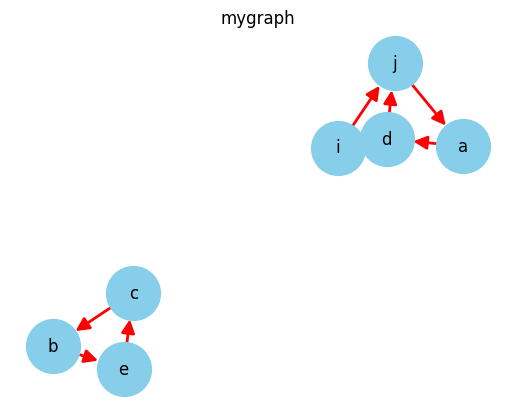

Graph built with 7 nodes and 8 edges


([['b', 'e', 'c'], ['a', 'd', 'i', 'j'], ['a', 'd', 'j']],
 [[('b', 'e'), ('e', 'c'), ('c', 'b')],
  [('a', 'd'), ('d', 'i'), ('i', 'j'), ('j', 'a')],
  [('a', 'd'), ('d', 'j'), ('j', 'a')]])

In [27]:
_nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
_nodes = ['a', 'd', 'i', 'j', 'b', 'c', 'e']

_edges = [('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'e'), ('b', 'f'), ('c', 'g'), ('c', 'h'), ('d', 'i'), ('d', 'j'), ('i', 'j'), ('j', 'a')]
_edges = [('a', 'd'), ('d', 'i'), ('d', 'j'), ('i', 'j'), ('j', 'a')]
_edges = [('a', 'd'), ('d', 'i'), ('d', 'j'), ('i', 'j'), ('j', 'a'), ('c', 'b'), ('b', 'e'), ('e', 'c')]
build_graph(_nodes, _edges, search_and_highlight_cycles=True, plot_interactive_graph=True, plot_graph=True)


In [39]:
!pip install graph-tool

ERROR: Could not find a version that satisfies the requirement graph-tool (from versions: none)
ERROR: No matching distribution found for graph-tool


In [ ]:
!pip install directedgraph

In [15]:
import directedgraph as dg

# Create a directed graph
G = dg.()

# Add edges to the graph

# Find cycles
cycles = G.find_cycles()

AttributeError: module 'directedgraph' has no attribute 'DirectedGraph'

In [ ]:
import graph_tool.all as gt

# Create a directed graph
g = gt.Graph(directed=True)



nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', ' ', '!', '?', '.', ',', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
nodes = ['a', 'b', 'c', 'd', 'e', 'f']

edges = [('a', 'b'), ('b', 'c'), ('c', 'd'), ('d', 'e'), ('d', 'a'), ('e', 'f'), ('f', 'd')]



nodes_dict = {}

v_prop = g.new_vertex_property("string")
for n in nodes:
    v = g.add_vertex()
    v_prop[v] = n
    nodes_dict[n] = v

    
e_prop = g.new_edge_property("string")
for (n1, n2) in edges:
    e = g.add_edge(nodes_dict[n1], nodes_dict[n2])


for c in gt.all_circuits(g):
    print([v_prop[v] for v in c])
    # print(c)

In [9]:
import graph_tool.all as gt


# Create a directed graph
g = gt.Graph(directed=True)

# Add vertices
v0 = g.add_vertex()
v1 = g.add_vertex()
v2 = g.add_vertex()
v3 = g.add_vertex()
v4 = g.add_vertex()

# Add edges
e0 = g.add_edge(v0, v1)
e1 = g.add_edge(v1, v2)
e2 = g.add_edge(v2, v3)
e3 = g.add_edge(v3, v1)  # Creates a cycle

# Find cycles using all_circuits function
cycles = gt.topology.all_circuits(g)

# Print the cycles
for cycle in cycles:
    print(cycle)


ModuleNotFoundError: No module named 'graph_tool'

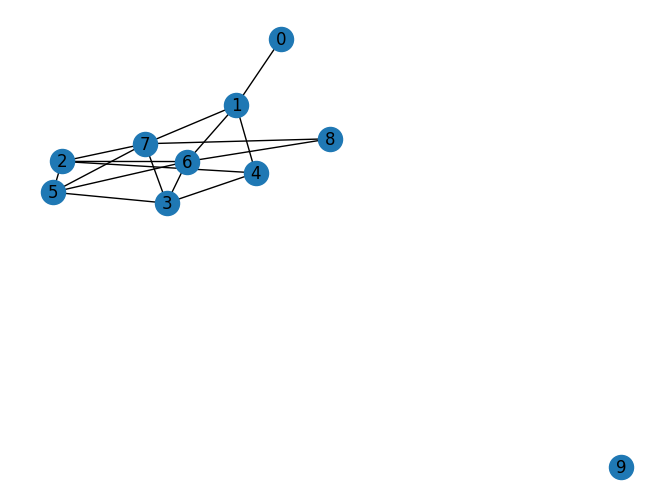

In [10]:

adjacency_list = [[1], [4, 6, 7], [4, 6, 7], [4, 6, 7], [2, 3], [2, 3], [5, 8], [5, 8], [], []]
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(range(len(adjacency_list)))

# Add edges based on the adjacency list
for node, neighbors in enumerate(adjacency_list):
    G.add_edges_from((node, neighbor) for neighbor in neighbors)


# Draw the graph
nx.draw(G, with_labels=True)

G.

In [70]:
G = [[1], [4, 6, 7], [4, 6, 7], [4, 6, 7], [2, 3], [2, 3], [5, 8], [5, 8], [], []]
N = len(G)

points = []
marked_stack = []
marked = [False for _ in range(0,N)]

g = None
def tarjan(s, v, f):
    global g
    points.append(v)
    marked_stack.append(v)
    marked[v] = True

    for w in G[v][:]:
        if w < s:            
            G[v].pop(G[v].index(w))
        elif w == s:
            print(points)
            f = True
        elif marked[w] == False:
            if f == g and f == False:
                f = False
            else:
                f = True
            tarjan(s, w, g)

    g = f
    
    if f == True:
        u = marked_stack.pop()
        while (u != v):
            marked[u] = False
            u = marked_stack.pop()
        #v is now deleted from mark stacked, and has been called u
        #unmark v
        marked[u] = False
    points.pop(points.index(v))

for i in range(0,N):
    marked[i] = False

for i in range(0,N):
    points = []
    tarjan(i,i, False)
    while (len(marked_stack) > 0):
        u = marked_stack.pop()
        marked[u] = False

[2, 4]
[2, 4, 3, 6, 5]
[2, 4, 3, 7, 5]
[2, 6, 5]
[2, 6, 5, 3, 4]
[2, 7, 5]
[2, 7, 5, 3, 4]
[3, 4]
[3, 6, 5]
[3, 7, 5]


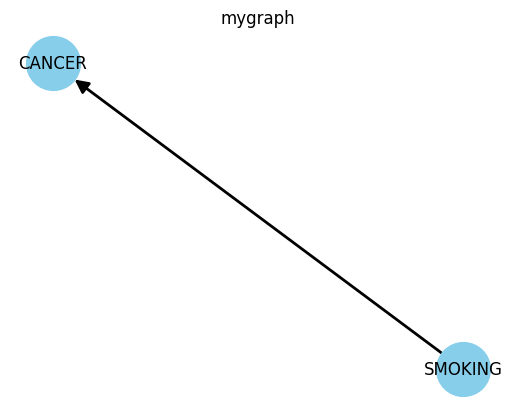

([], [])

In [155]:
build_graph(['SMOKING', 'CANCER'], [('SMOKING', 'CANCER')])

# Continue

In [19]:
def causal_discovery_pipeline(text_title, text, entities=[], use_text_in_causal_discovery=False, use_LLM_pretrained_knowledge_in_causal_discovery=False, reverse_edge_for_variable_check=False, optimize_found_entities=True, use_text_in_entity_optimization=True, search_cycles=True, plot_static_graph=True, graph_directory_name='../graphs', verbose=False):
    if verbose:
        print('Text:')
        print(text)
        print('--')

    if entities == []:
        entities = gpt_ner(text)
    else:
        if verbose:
            print('Skipping NER operation. Using provided entities.')
            print('--')

    if verbose:
        print(f'Entities: ({len(entities)})')
        print(entities)
        print('--')

    if optimize_found_entities:
        opt_entities = optimize_entities(entities, text=(text if use_text_in_entity_optimization else None))

        entities = list(opt_entities.keys())



        if verbose:
            print(f'Optimized Entities: ({len(entities)})')
            print(entities)

    graph_edges = gpt_causal_discovery(entities, text=(text if use_text_in_causal_discovery else None), use_pretrained_knowledge=use_LLM_pretrained_knowledge_in_causal_discovery, reverse_variable_check=reverse_edge_for_variable_check, verbose=verbose)
    
    edges = extract_edge_answers(graph_edges)
    if verbose:
        print('Edges:')
        print(edges)
        print('--')

    if reverse_edge_for_variable_check:
        valid_edges, invalid_edges = check_invalid_answers(edges)
        if verbose:
            print('Valid Edges:')
            print(valid_edges)
            print('--')
            print('Invalid Edges:')
            print(invalid_edges)
            print('--')
        
        edge_correction_response = correct_invalid_edges(invalid_edges, text, use_pretrained_knowledge=use_LLM_pretrained_knowledge_in_causal_discovery)
        corrected_edges = extract_edge_answers(edge_correction_response)
        if verbose:
            print('Edge Correction Response:')
            print(corrected_edges)
            print('--')

        valid_edges.extend(corrected_edges)
        edges = valid_edges
    
    nodes, processed_edges, bidirected_edges, graph = preprocess_edges(edges)

    if verbose:
        print('Nodes:')
        print(nodes)
        print('--')
        print('Processed Edges:')
        print(processed_edges)
        print('--')

    cycles = []
    if search_cycles:
        start = time.time()
        print(f'Looking for cycles... {datetime.now().strftime("%H:%M:%S %d/%m/%Y")}')
        cycles = find_cycles(nodes=nodes, edges=processed_edges)
        elapsed_seconds = time.time() - start
        print(f'{len(cycles)} cycles found - exec time : {time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds))}')
    build_graph(nodes=nodes, edges=processed_edges, bidirected_edges=bidirected_edges, cycles=cycles, plot_static_graph=plot_graph, directory_name=graph_directory_name, graph_name=text_title)
    
    if verbose:
        if cycles:
            print('GRAPH IS CYCLIC')
        else:
            print('Graph is acyclic')
        
        print('--')

    if verbose:
        print_edges(graph_edges)
    
    return nodes, processed_edges + bidirected_edges, cycles

In [18]:
def causal_discovery_pipeline(text_title, text, entities=[], use_text_in_causal_discovery=False, use_LLM_pretrained_knowledge_in_causal_discovery=False, reverse_edge_for_variable_check=False, optimize_found_entities=True, use_text_in_entity_optimization=True, search_cycles=True, plot_graphs=True, plot_interactive_graph=True, graph_directory_name='../graphs', verbose=False):
    if verbose:
        print('Text:')
        print(text)
        print('--')

    if entities == []:
        entities = gpt_ner(text)
    else:
        if verbose:
            print('Skipping NER operation. Using provided entities.')
            print('--')

    if verbose:
        print(f'Entities: ({len(entities)})')
        print(entities)
        print('--')

    if optimize_found_entities:
        opt_entities = optimize_entities(entities, text=(text if use_text_in_entity_optimization else None))

        entities = list(opt_entities.keys())



        if verbose:
            print(f'Optimized Entities: ({len(entities)})')
            print(entities)

    graph_edges = gpt_causal_discovery(entities, text=(text if use_text_in_causal_discovery else None), use_pretrained_knowledge=use_LLM_pretrained_knowledge_in_causal_discovery, reverse_variable_check=reverse_edge_for_variable_check, verbose=verbose)
    
    edges = extract_edge_answers(graph_edges)
    if verbose:
        print('Edges:')
        print(edges)
        print('--')

    if reverse_edge_for_variable_check:
        valid_edges, invalid_edges = check_invalid_answers(edges)
        if verbose:
            print('Valid Edges:')
            print(valid_edges)
            print('--')
            print('Invalid Edges:')
            print(invalid_edges)
            print('--')
        
        edge_correction_response = correct_invalid_edges(invalid_edges, text, use_pretrained_knowledge=use_LLM_pretrained_knowledge_in_causal_discovery)
        corrected_edges = extract_edge_answers(edge_correction_response)
        if verbose:
            print('Edge Correction Response:')
            print(corrected_edges)
            print('--')

        valid_edges.extend(corrected_edges)
        edges = valid_edges
    
    nodes, processed_edges, bidirected_edges, graph = preprocess_edges(edges)

    if verbose:
        print('Nodes:')
        print(nodes)
        print('--')
        print('Processed Edges:')
        print(processed_edges)
        print('--')

    cycles, cycles_edges = find_cycles(nodes=nodes, edges=processed_edges)
    cycles, cycles_edges = build_graph(nodes=nodes, edges=processed_edges, bidirected_edges=bidirected_edges, search_and_highlight_cycles=search_cycles, plot_interactive_graph=plot_interactive_graph, plot_graph=plot_graphs, directory_name=graph_directory_name, graph_name=text_title)
    if verbose:
        if cycles:
            print('GRAPH IS CYCLIC')
        else:
            print('Graph is acyclic')
        
        print('--')

    if verbose:
        print_edges(graph_edges)
    
    return nodes, processed_edges + bidirected_edges, cycles

In [31]:
def smoking_test():
    text = 'Smoking involves inhaling tobacco fumes and it causes lung cancer and tumors.'
    text_title = 'Smoking - test'
    causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=False, optimize_found_entities=True, use_text_in_entity_optimization=True, search_cycles=True, plot_graphs=False, plot_interactive_graph=True, verbose=True)

In [32]:
smoking_test()

Text:
Smoking involves inhaling tobacco fumes and it causes lung cancer and tumors.
--
Entities: (4)
['Smoking', 'inhaling tobacco fumes', 'lung cancer', 'tumors']
--
Optimized Entities: (3)
['Smoking', 'lung cancer', 'tumors']
0 = Smoking, 1 = lung cancer
(('Smoking', 'lung cancer'), 'The provided text states that "Smoking involves inhaling tobacco fumes and it causes lung cancer and tumors." This sentence directly indicates a cause-and-effect relationship between the two entities: "Smoking" and "lung cancer". \n\nThe text suggests that the act of smoking, which involves inhaling tobacco fumes, leads to the development of lung cancer. This aligns with widely accepted medical knowledge that smoking is a significant risk factor for lung cancer due to the harmful substances in tobacco smoke.\n\nTherefore, the relationship between "Smoking" and "lung cancer" is not that "lung cancer" provokes "Smoking", nor is there a common factor causing both. The text also clearly states a direct causa

# Tests

Text:
'X' is caused by 'Z'; 'X' provokes 'Y'; 'Y' causes 'Z'
--
<Answer><Entity>X</Entity><Entity>Z</Entity><Entity>Y</Entity></Answer>
Entities: (3)
['X', 'Z', 'Y']
--
0 = X, 1 = Z
(('X', 'Z'), 'To determine the most likely cause-and-effect relationship between "X" and "Z" based on the given information, we can analyze the statements.\n\n1. "X" is caused by "Z": This suggests that "Z" is the cause and "X" is the effect. This indicates that "Z" precedes "X".\n\n2. "X" provokes "Y": This implies that "X" is capable of triggering or inducing "Y". So, "X" can be seen as a cause for "Y".\n\n3. "Y" causes "Z": This statement suggests that "Y" is the cause and "Z" is the effect. Therefore, "Z" follows "Y".\n\nBased on these statements, we can infer that "Z" is caused by "Y", and "X" provokes "Y". However, we do not have direct information about the relationship between "X" and "Z".\n\nTherefore, the most likely cause-and-effect relationship between "X" and "Z" is that there is a common facto

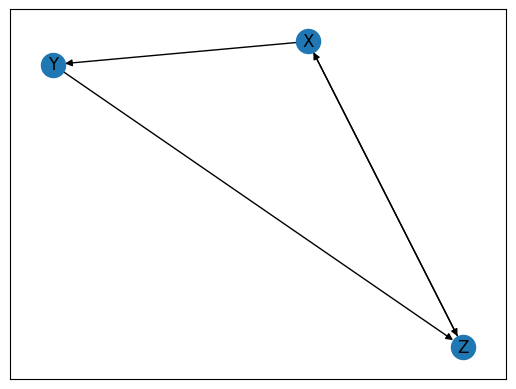

In [21]:
text = '\'X\' is the main cause for \'Y\'; \'Y\' causes \'Z\'; \'Z\' is the main cause for \'X\''
text = '\'X\' is caused by \'Z\'; \'X\' provokes \'Y\'; \'Y\' causes \'Z\''
text_title = 'cyclic_graph'
nodes, edges = causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=False, reverse_edge_for_variable_check=False, optimize_found_entities=False, use_text_in_entity_optimization=False, verbose=True)

Text:
Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.
--
Skipping NER operation. Using provided entities.
Entities: (7)
['visit to Asia', 'tubercolosis', 'lung cancer', 'bronchitis', 'dyspnoea', 'smoking', 'positive X-ray']
--
Optimized Entities: (7)
['visit to Asia', 'tuberculosis', 'lung cancer', 'bronchitis', 'dyspnoea', 'smoking', 'positive X-ray']
--
0 = visit to Asia, 1 = tuberculosis
(('visit to Asia', 'tuberculosis'), 'Step 1: Identify the entities and determine their causal relationship.\n\nThe entities in question are "visit to Asia" and "tuberculosis". To determine their causal relationship, we need to consider 

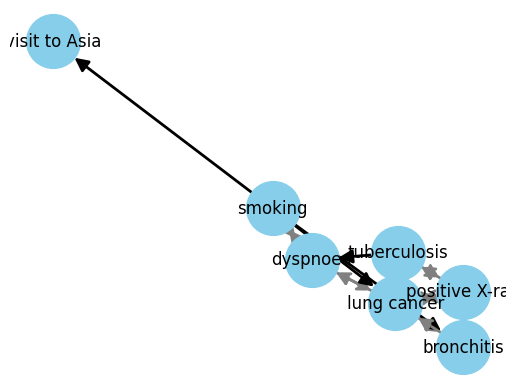

../graphs/Asia_886474714868927.html
Graph is acyclic
--
visit to Asia   tuberculosis
visit to Asia   lung cancer
visit to Asia   dyspnoea
visit to Asia <- smoking
visit to Asia None positive X-ray
tuberculosis <-> lung cancer
tuberculosis   bronchitis
tuberculosis -> dyspnoea
tuberculosis   smoking
tuberculosis <-> positive X-ray
lung cancer <-> bronchitis
lung cancer <-> dyspnoea
lung cancer <- smoking
lung cancer <-> positive X-ray
bronchitis   dyspnoea
bronchitis <- smoking
bronchitis <-> positive X-ray
dyspnoea <-> smoking
dyspnoea   positive X-ray
smoking   positive X-ray


In [161]:
import time
text = 'Smoking involves inhaling tobacco fumes; it can cause lung cancer and tumors.'
ground_truth_nodes = ['visit to Asia', 'tubercolosis', 'lung cancer', 'bronchitis', 'dyspnoea', 'smoking', 'positive X-ray']
text = 'Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.'
text_title = f'Asia_{time.time().as_integer_ratio()[0]}'
nodes, edges, cycles = _causal_discovery_pipeline(text_title, text, entities=ground_truth_nodes, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=False, reverse_edge_for_variable_check=False, optimize_found_entities=False, use_text_in_entity_optimization=False, search_cycles=True, plot_interactive_graph=True, verbose=True)

Text:
Smoking involves inhaling tobacco fumes, and it can cause lung cancer and tumors.
--
Skipping NER operation. Using provided entities.
--
Entities: (4)
['smoking', 'tobacco fumes', 'lung cancer', 'tumors']
--
0 = smoking, 1 = tobacco fumes
(('smoking', 'tobacco fumes'), 'To determine the most likely cause-and-effect relationship between "smoking" and "tobacco fumes" based on the provided information, let\'s analyze the situation step-by-step:\n\n1. The text states that "Smoking involves inhaling tobacco fumes."\n2. The text also mentions that "it can cause lung cancer and tumors."\n\nBased on this information, we can infer the following:\n\n1. Smoking involves inhaling tobacco fumes.\n2. Smoking can cause lung cancer and tumors.\n\nFrom these statements, we can conclude that smoking is the cause and tobacco fumes are the effect. Therefore, the most likely cause-and-effect relationship between "smoking" and "tobacco fumes" is:\n\nA: "smoking" leads to "tobacco fumes"\n\nTherefore, 

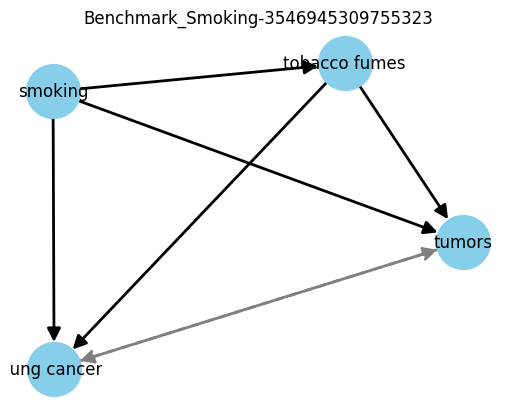

Graph is acyclic
--
smoking -> tobacco fumes
smoking -> lung cancer
smoking -> tumors
tobacco fumes -> smoking
tobacco fumes -> lung cancer
tobacco fumes -> tumors
lung cancer <- smoking
lung cancer <- tobacco fumes
lung cancer <-> tumors
tumors <- smoking
tumors <- tobacco fumes
tumors <-> lung cancer


In [33]:
import time
ground_truth_nodes = ['smoking', 'tobacco fumes', 'lung cancer', 'tumors']
text = 'Smoking involves inhaling tobacco fumes, and it can cause lung cancer and tumors.'
text_title = f'Benchmark_Smoking-{time.time().as_integer_ratio()[0]}'
nodes, edges, cycles = _causal_discovery_pipeline(text_title, text, entities=ground_truth_nodes, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=True, optimize_found_entities=False, use_text_in_entity_optimization=False, search_cycles=True, plot_interactive_graph=False, verbose=True)

Text:
Smoking involves inhaling tobacco fumes; it can cause lung cancer and tumors.
--
Skipping NER operation. Using provided entities.
--
Entities: (4)
['smoking', 'tobacco fumes', 'lung cancer', 'tumors']
--
0 = smoking, 1 = tobacco fumes
(('smoking', 'tobacco fumes'), 'Step 1: Identify the cause and effect mentioned in the text.\nCause: Smoking\nEffect: Lung cancer and tumors\n\nStep 2: Determine the relationship between the entities "smoking" and "tobacco fumes" based on the given information.\nThe text states that smoking involves inhaling tobacco fumes. This suggests that smoking is the cause and tobacco fumes are the result or effect.\n\nStep 3: Analyze the options:\nA. "smoking" causes "tobacco fumes" - This is not supported by the given information. The text states that smoking involves inhaling tobacco fumes, indicating that smoking is the cause and tobacco fumes are the result.\nB. "tobacco fumes" causes "smoking" - This is not supported by the given information. The text do

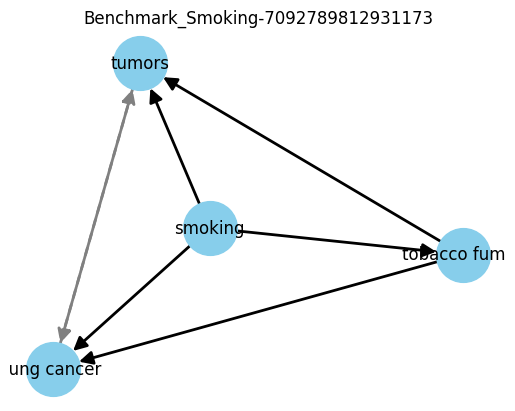

../graphs/Benchmark_Smoking-7092789812931173.html
Graph is acyclic
--
smoking -> tobacco fumes
smoking -> lung cancer
smoking -> tumors
tobacco fumes -> lung cancer
tobacco fumes -> tumors
lung cancer <-> tumors


In [29]:
import time
ground_truth_nodes = ['smoking', 'tobacco fumes', 'lung cancer', 'tumors']
text = 'Smoking involves inhaling tobacco fumes; it can cause lung cancer and tumors.'
text_title = f'Benchmark_Smoking-{time.time().as_integer_ratio()[0]}'
nodes, edges, cycles = _causal_discovery_pipeline(text_title, text, entities=ground_truth_nodes, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=False, reverse_edge_for_variable_check=False, optimize_found_entities=False, use_text_in_entity_optimization=False, search_cycles=True, plot_interactive_graph=True, verbose=True)

# Misc (Kahn, old functions, ...)

In [73]:
def ___has_cycle(graph):
  """
  Checks if a directed graph has a cycle.

  Args:
    graph: A directed graph represented as a dictionary. The keys of the dictionary are the nodes in the graph, and the values are lists of the nodes that the given node points to.

        graph = {
        "A": ["B", "C"],
        "B": ["C"],
        "C": []
        }
    
  Returns:
    True if the graph has a cycle, False otherwise.
  """

  visited = set()
  stack = []

  for node in graph:

    print(f'node = {node}')  # delete


    # if node in visited:
    #   return True

    # stack.append(node)
    # # visited.add(node)
    # visited.add(node)

    
    if node not in visited:
      visited.add(node)
      stack.append(node)

    while stack:
      print(f'stack = {stack}')  # delete
      print(f'visited = {visited}')  # delete
      
      current_node = stack.pop()

      print(f'current_node = {current_node}')  # delete


      for neighbor in graph[current_node]:

        print(f'neighbor = {neighbor}')  # delete
        
        if neighbor in visited:
          return True

        stack.append(neighbor)
        visited.add(neighbor)

  return False


# {0: [1], 1: [2], 2: [3], 3: []}

# node = 0
# stack = [0]
# current_node = 0
# neighbor = 1
# stack = [1]
# current_node = 1
# neighbor = 2
# stack = [2]
# current_node = 2
# neighbor = 3
# stack = [3]
# current_node = 3
# node = 1




# {0: [1, 2], 1: [2], 2: [3, 5], 3: [4, 5]}

#  node = 0
#  current_node = 0
#  current_node = 2
#  current_node = 5

In [72]:
def __has_cycle(graph):
  """
  Checks if a directed graph has a cycle.

  Args:
    graph: A directed graph represented as a dictionary. The keys of the dictionary are the nodes in the graph, and the values are lists of the nodes that the given node points to.

        graph = {
        "A": ["B", "C"],
        "B": ["C"],
        "C": []
        }
    
  Returns:
    True if the graph has a cycle, False otherwise.
  """

  visited = set()
  stack = []

  for node in graph:

    print(f'node = {node}')  # delete


    # if node in visited:
    #   return True

    # stack.append(node)
    # # visited.add(node)
    # visited.add(node)

    
    if node not in visited:
      visited.add(node)
      stack.append(node)

    while stack:
      print(f'stack = {stack}')  # delete
      print(f'visited = {visited}')  # delete
      
      current_node = stack.pop()

      print(f'current_node = {current_node}')  # delete
      
      temp_visited = visited

      for neighbor in graph[current_node]:

        print(f'neighbor = {neighbor}')  # delete
        
        if neighbor in temp_visited:
          return True

        stack.append(neighbor)
        temp_visited.add(neighbor)
        # visited.add(neighbor)

  return False


# {0: [1], 1: [2], 2: [3], 3: []}

# node = 0
# stack = [0]
# current_node = 0
# neighbor = 1
# stack = [1]
# current_node = 1
# neighbor = 2
# stack = [2]
# current_node = 2
# neighbor = 3
# stack = [3]
# current_node = 3
# node = 1




# {0: [1, 2], 1: [2], 2: [3, 5], 3: [4, 5]}

#  node = 0
#  current_node = 0
#  current_node = 2
#  current_node = 5

In [25]:
def __prepare_graph_for_acyclicity_check(edges):
    graph = {}
    nodes = set()
    nodes_without_incoming_edges = set()
    nodes_with_incoming_edges = set()

    for (n1, n2), answer in edges:
        nodes.add(n1)
        if n1 not in graph:
            graph[n1] = []
        if n2 not in graph:
            graph[n2] = []
            
        if answer == 'A':
            graph[n1].append(n2)
            nodes_with_incoming_edges.add(n2)
        if answer == 'B':
            graph[n2].append(n1) 
            nodes_with_incoming_edges.add(n1)

    nodes_without_incoming_edges = nodes - nodes_with_incoming_edges
    # print(f'{nodes} - {nodes_with_incoming_edges} = {nodes_without_incoming_edges}')
        

    return graph, nodes_without_incoming_edges


In [64]:
def _prepare_graph_for_acyclicity_check(edges):
    graph = {}
    nodes = set()
    processed_edges = set()

    for (n1, n2), answer in edges:
        nodes.add(n1)
        nodes.add(n2)

        if n1 not in graph:
            graph[n1] = []
        if n2 not in graph:
            graph[n2] = []
            
        if answer == 'A':
            graph[n1].append(n2)
            processed_edges.add((n1, n2))
        if answer == 'B':
            graph[n2].append(n1)       
            processed_edges.add((n2, n1))
        elif answer == 'D':
            processed_edges.add((n1, n2))
            processed_edges.add((n2, n1))

    return nodes, processed_edges, graph

In [71]:
def _has_cycle(graph):
    def dfs(node, visited, recursion_stack):
        if node in recursion_stack:
            return True
        if node in visited:
            return False

        visited.add(node)
        recursion_stack.add(node)

        for neighbor in graph.get(node, []):
            if dfs(neighbor, visited, recursion_stack):
                return True

        recursion_stack.remove(node)
        return False

    visited = set()
    for node in graph:
        if node not in visited:
            if dfs(node, visited, set()):
                return True

    return False

[(('1', '2'), 'B'), (('1', '3'), 'A'), (('1', '4'), 'C'), (('1', '5'), 'C'), (('2', '3'), 'B'), (('2', '4'), 'A'), (('2', '5'), 'A'), (('3', '4'), 'B'), (('3', '5'), 'A'), (('4', '5'), 'C')]
../graphs/mygraph.html


True

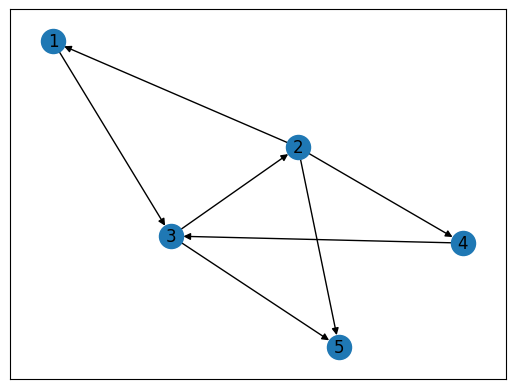

In [72]:
edges = [(('X', 'Y'), 'A'), (('Y', 'Z'), 'A'), (('T', 'Z'), 'B'), (('X', 'T'), 'C')]        # no cycle
# edges = [(('X', 'Y'), 'A'), (('Y', 'Z'), 'A'), (('T', 'Z'), 'B'), (('X', 'T'), 'B'), (('T', 'A'), 'A')]        # has cycle

import random
import string

# generate random edges
edges = []
nodes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
nodes = ['1', '2', '3', '4', '5']

for i, n1 in enumerate(nodes):
    for j, n2 in enumerate(nodes):
        if n1 == n2 or i >= j:
            continue
        answer = random.choice(['A', 'B', 'C', 'D'])
        edges.append(((n1, n2), answer))

print(edges)

nodes, edges, graph = _prepare_graph_for_acyclicity_check(edges)
plot_interactive_graph(nodes, edges)
plot_graph(nodes, edges)
_has_cycle(graph)


# TODO : DFS instead of Kahn algorithm (?)
# TODO : update documentation

In [6]:
def preprocess_edges(edges):
    nodes = set()
    processed_edges = set()
    directed_edges = set()
    nodes_with_incoming_edges = set()

    for (n1, n2), answer in edges:

        nodes.add(n1)
        nodes.add(n2)

        if answer == 'A':
            processed_edges.add((n1, n2))
            directed_edges.add((n1, n2))
            nodes_with_incoming_edges.add(n2)
        elif answer == 'B':
            processed_edges.add((n2, n1))
            directed_edges.add((n2, n1))
            nodes_with_incoming_edges.add(n1)
        elif answer == 'D':
            processed_edges.add((n1, n2))
            processed_edges.add((n2, n1))
            

    nodes_without_incoming_edges = nodes - nodes_with_incoming_edges        

    return nodes, processed_edges, directed_edges, nodes_without_incoming_edges





def prepare_graph_for_acyclicity_check(edges):
    nodes = set()
    processed_edges = set()
    nodes_with_incoming_edges = set()

    for (n1, n2), answer in edges:
        nodes.add(n1)
            
        if answer == 'A':
            nodes_with_incoming_edges.add(n2)
            processed_edges.add((n1, n2))
        if answer == 'B':
            nodes_with_incoming_edges.add(n1)
            processed_edges.add((n2, n1))

    nodes_without_incoming_edges = nodes - nodes_with_incoming_edges        

    return nodes, processed_edges, nodes_without_incoming_edges



# TODO 1: unify 'preprocess_edges' and 'prepare_graph_for_acyclicity_check', they are doing almost the same thing (the latter has the additional steps 
#       of 1. collecting nodes without incoming edges and 2. edges to be considered for the acyclicity check --> only single direction edges and no bidirected edges)

# TODO 2: decide what to do if graph is not acyclical (--> re-query to remove cycle ??)

# TODO 3: update documentation with the acyclicity check

# TODO 4: update documentation with introductive theory on causal analysis and discovery

# TODO 5: benchmarks
        # 5.1. in code
        # 5.2. in documentation


In [5]:
# def kahn_acyclicity_check(graph, nodes_without_incoming_edges = set()):
def kahn_acyclicity_check(edges, nodes_without_incoming_edges = set()):

    '''
    Kahn's algorithm for checking acyclicity of a directed graph.

    Args:
        graph: A directed graph represented as a dictionary. The keys of the dictionary are the nodes in the graph, and the values are lists of the nodes that the given node points to.
        nodes_without_incoming_edges: A set of nodes that have no incoming edges.

    Returns:
        True if the graph is acyclic, False otherwise.
    '''

    '''
    L ← Empty list that will contain the sorted elements
    S ← Set of all nodes with no incoming edge

    while S is not empty do
        remove a node n from S
        add n to L
        for each node m with an edge e from n to m do
            remove edge e from the graph
            if m has no other incoming edges then
                insert m into S

    if graph has edges then
        return error   (graph has at least one cycle)
    else 
        return L   (a topologically sorted order)

    '''

    L = []

    while nodes_without_incoming_edges:
        n = nodes_without_incoming_edges.pop()
        L.append(n)

        # for m children of n
        for m in [tup for tup in edges if tup[0] == n]:

            edges.remove((n, m[1]))
            # if m has no more parent nodes
            if not [tup for tup in edges if tup[1] == m[1]]:
                nodes_without_incoming_edges.add(m[1])


    if edges:
        return True
    else:
        return False

In [15]:
edges = [(('X', 'Y'), 'A'), (('Y', 'Z'), 'A'), (('T', 'Z'), 'B'), (('X', 'T'), 'C')]        # no cycle
edges = [(('X', 'Y'), 'A'), (('Y', 'Z'), 'A'), (('T', 'Z'), 'B'), (('X', 'T'), 'B'), (('T', 'A'), 'A')]        # has cycle


nodes, processed_edges, directed_edges, nodes_without_incoming_edges = preprocess_edges(edges)
print(kahn_acyclicity_check(directed_edges, nodes_without_incoming_edges))
plot_interactive_graph(nodes, processed_edges)

edges = {('X', 'Y'), ('Y', 'Z'), ('T', 'A'), ('Z', 'T'), ('T', 'X')}
nodes_without_incoming_edges = set()
True
../graphs/mygraph.html.html


In [115]:
edges = [(0,1), (1,2), (1,3), (2,3), (3,0), (3, 1)]

child_node_edges = [tup for tup in edges if tup[0] == 1]
parent_node_edges = [tup for tup in edges if tup[1] == 1]

# print(f'child_node_edges = {child_node_edges}')
# print(f'parent_node_edges = {parent_node_edges}')


# edges = [((0, 1), 'A'), ((1, 2), 'A'), ((3, 2), 'B'), ((0, 3), 'C')]        # no cycle
# # edges = [((0, 1), 'A'), ((1, 2), 'A'), ((3, 2), 'B'), ((0, 3), 'B')]        # has cycle

# graph, nodes_without_incoming_edges = prepare_graph_for_acyclicity_check(edges)

# graph = [(0,1), (1,2), (2,3)]               # no cycle
# # graph = [(0,1), (1,2), (2,3), (3,0)]        # has cycle


edges = [(('X', 'Y'), 'A'), (('Y', 'Z'), 'A'), (('T', 'Z'), 'B'), (('X', 'T'), 'C')]        # no cycle
edges = [(('X', 'Y'), 'A'), (('Y', 'Z'), 'A'), (('T', 'Z'), 'B'), (('X', 'T'), 'B')]        # has cycle

graph, nodes_without_incoming_edges = prepare_graph_for_acyclicity_check(edges)

graph = [('X','Y'), ('Y','Z'), ('Z','T')]               # no cycle
graph = [('X','Y'), ('Y','Z'), ('Z','T'), ('T','X')]        # has cycle

kahn_acyclicity_check(graph, nodes_without_incoming_edges)

edges = [('X', 'Y'), ('Y', 'Z'), ('Z', 'T'), ('T', 'X')]
nodes_without_incoming_edges = set()


True

In [88]:
edges = [((1, 0), 'B'), ((0, 2), 'A'), ((1, 2), 'A'), ((3, 2), 'B'), ((3, 4), 'A'), ((3, 5), 'A'), ((2, 5), 'B'), ((0, 3), 'C'), ((0, 4), 'C'), ((5, 0), 'C')]        # has cycle
edges = [((1, 0), 'B'), ((0, 2), 'A'), ((1, 2), 'A'), ((3, 2), 'B'), ((3, 4), 'A'), ((3, 5), 'A'), ((2, 5), 'A'), ((0, 3), 'C'), ((0, 4), 'C'), ((5, 0), 'C')]        # no cycle

edges = [((0, 1), 'A'), ((1, 2), 'A'), ((3, 2), 'B'), ((0, 3), 'C')]        # no cycle
# edges = [((0, 1), 'A'), ((1, 2), 'A'), ((3, 2), 'B'), ((0, 3), 'B')]        # has cycle

print(prepare_graph_for_acyclicity_check(edges))

({0: [1], 1: [2], 2: [3], 3: []}, {0})


In [76]:
# (('X', 'Y'), 'A'), ('X', 'Y', 'A')

graph = {
    0: [1, 2],
    1: [2],
    2: [3],
    3: [4, 5],
    4: [],
    5: [2]
}



def check_graph_acyclicity(edges):
    graph = {}

    for (n1, n2), answer in edges:
        if n1 not in graph:
            graph[n1] = []
        if n2 not in graph:
            graph[n2] = []
        if answer == 'A':
            # if n1 not in graph:
            #     graph[n1] = []
            graph[n1].append(n2)
        if answer == 'B':
            # if n2 not in graph:
            #     graph[n2] = []
            graph[n2].append(n1) 

    return graph


edges = [((1, 0), 'B'), ((0, 2), 'A'), ((1, 2), 'A'), ((3, 2), 'B'), ((3, 4), 'A'), ((3, 5), 'A'), ((2, 5), 'B'), ((0, 3), 'C'), ((0, 4), 'C'), ((5, 0), 'C')]        # has cycle
# edges = [((1, 0), 'B'), ((0, 2), 'A'), ((1, 2), 'A'), ((3, 2), 'B'), ((3, 4), 'A'), ((3, 5), 'A'), ((2, 5), 'A'), ((0, 3), 'C'), ((0, 4), 'C'), ((5, 0), 'C')]        # no cycle

# edges = [((0, 1), 'A'), ((1, 2), 'A'), ((3, 2), 'B'), ((0, 3), 'C')]        # no cycle
# edges = [((0, 1), 'A'), ((1, 2), 'A'), ((3, 2), 'B'), ((0, 3), 'B')]        # has cycle

print(check_graph_acyclicity(edges))

has_cycle(check_graph_acyclicity(edges))


{1: [2], 0: [1, 2], 2: [3], 3: [4, 5], 4: [], 5: [2]}
node = 1
stack = [1]
visited = {1}
current_node = 1
neighbor = 2
stack = [2]
visited = {1, 2}
current_node = 2
neighbor = 3
stack = [3]
visited = {1, 2, 3}
current_node = 3
neighbor = 4
neighbor = 5
stack = [4, 5]
visited = {1, 2, 3, 4, 5}
current_node = 5
neighbor = 2


True

In [40]:
edges = [('0', '1'), ('0', '2'), ('1', '2'), ('2', '3'), ('2', '5'), ('3', '4'), ('3', '5')]        # no cycle
plot_interactive_graph(['0', '1', '2', '3', '4', '5'], edges, name='test_no_cycle')

edges = [('0', '1'), ('0', '2'), ('1', '2'), ('2', '3'), ('3', '4'), ('3', '5'), ('5', '2')]        # has cycle
plot_interactive_graph(['0', '1', '2', '3', '4', '5'], edges, name='test_cycle')

../graphs/test_no_cycle.html
../graphs/test_cycle.html


In [22]:
text = 'Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.'

entities = gpt_ner(text)

print(f'Entities: ({len(entities)})')
print(entities)
print('--')

opt_entities = optimize_entities(entities, text)
# opt_entities = optimize_entities(entities)
  
print(f'Optimized Entities: ({len(opt_entities)})')
print(opt_entities)
print('--')

<Answer><Entity>Shortness-of-breath</Entity><Entity>dyspnoea</Entity><Entity>tuberculosis</Entity><Entity>lung cancer</Entity><Entity>bronchitis</Entity><Entity>Asia</Entity><Entity>smoking</Entity><Entity>risk factor</Entity><Entity>chest X-ray</Entity></Answer>
Entities: (9)
['Shortness-of-breath', 'dyspnoea', 'tuberculosis', 'lung cancer', 'bronchitis', 'Asia', 'smoking', 'risk factor', 'chest X-ray']
--
Optimized Entities: (7)
['Shortness-of-breath', 'tuberculosis', 'lung cancer', 'bronchitis', 'smoking', 'risk factor', 'chest X-ray']
--


In [16]:
# pre build_graph function (with grey, dashed bidirectional edges and cycle highlighting)

def has_cycle(graph):
    """
    Checks if a directed graph has a cycle.

    Args:
        graph: A directed graph represented as a dictionary. The keys of the dictionary are the nodes in the graph, and the values are lists of the nodes that the given node points to.

            graph = {
            "A": ["B", "C"],
            "B": ["C"],
            "C": []
            }
        
    Returns:
        True if the graph has a cycle, False otherwise.
  """

  # visits 

    def dfs(node, visited, recursion_stack):
        if node in recursion_stack:
            return True
        if node in visited:
            return False

        visited.add(node)
        recursion_stack.add(node)

        for neighbor in graph.get(node, []):
            if dfs(neighbor, visited, recursion_stack):
                return True

        recursion_stack.remove(node)
        return False

    visited = set()
    for node in graph:
        if node not in visited:
            if dfs(node, visited, set()):
                return True

    return False

In [2]:
# pre build_graph function (with grey, dashed bidirectional edges and cycle highlighting)

import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(nodes, edges):

    if not nodes:
        return None
    
    # Create a graph
    G = nx.DiGraph()

    # Add nodes
    for node in nodes:
        G.add_node(node)

    # Add edges
    for e1, e2 in edges:
        G.add_edge(e1, e2)

    # Plot the graph
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos, arrows=True)
    nx.draw_networkx_labels(G, pos)

In [138]:
# pre build_graph function (with grey, dashed bidirectional edges and cycle highlighting)

from pyvis.network import Network

def plot_interactive_graph(nodes, edges, name='mygraph'):
    
    if not nodes:
        return None
    
    net = Network(directed=True, notebook=True)
    net.force_atlas_2based()
    net.show_buttons(filter_=['physics']) 

    node_ids = {}

    for i, node in enumerate(nodes):
        net.add_node(i, label=node)
        node_ids[node] = i
    
    for e1, e2 in edges:
        net.add_edge(source=node_ids[e1], to=node_ids[e2], label='TEST LABEL')

    net.show(f'../graphs/{name}.html')

In [136]:
# pre build_graph function (with grey, dashed bidirectional edges and cycle highlighting)

def causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=False, use_LLM_pretrained_knowledge_in_causal_discovery=False, reverse_edge_for_variable_check=False, optimize_found_entities=True, use_text_in_entity_optimization=True, verbose=False):
    if verbose:
        print('Text:')
        print(text)
        print('--')

    entities = gpt_ner(text)

    if verbose:
        print(f'Entities: ({len(entities)})')
        print(entities)
        print('--')

    if optimize_found_entities:
        if use_text_in_entity_optimization:
            entities = optimize_entities(entities, text)
        else:
            entities = optimize_entities(entities)

        if verbose:
            print(f'Optimized Entities: ({len(entities)})')
            print(entities)
            print('--')

    if use_text_in_causal_discovery:
        graph_edges = gpt_causal_discovery(entities, text, use_pretrained_knowledge=use_LLM_pretrained_knowledge_in_causal_discovery, reverse_variable_check=reverse_edge_for_variable_check)
    else:
        graph_edges = gpt_causal_discovery(entities, use_pretrained_knowledge=use_LLM_pretrained_knowledge_in_causal_discovery, reverse_variable_check=reverse_edge_for_variable_check)


    edges = extract_edge_answers(graph_edges)
    if verbose:
        print('Edges:')
        print(edges)
        print('--')

    if reverse_edge_for_variable_check:
        valid_edges, invalid_edges = check_invalid_answers(edges)
        if verbose:
            print('Valid Edges:')
            print(valid_edges)
            print('--')
            print('Invalid Edges:')
            print(invalid_edges)
            print('--')
        
        edge_correction_response = correct_invalid_edges(invalid_edges, text, use_pretrained_knowledge=use_LLM_pretrained_knowledge_in_causal_discovery)
        corrected_edges = extract_edge_answers(edge_correction_response)
        if verbose:
            print('Edge Correction Response:')
            print(corrected_edges)
            print('--')

        valid_edges.extend(corrected_edges)
        edges = valid_edges
    
    nodes, processed_edges, graph = preprocess_edges(edges)
    is_graph_acyclic = not has_cycle(graph)

    if verbose:
        if is_graph_acyclic:
            print('Graph is acyclic')
        else:
            print('Graph is cyclic')
        
        print('--')

    if verbose:
        print('Nodes:')
        print(nodes)
        print('--')
        print('Processed Edges:')
        print(processed_edges)
        print('--')

    plot_graph(nodes, processed_edges)
    plot_interactive_graph(nodes, processed_edges, name=text_title)
    print_edges(graph_edges) # temporary edge print

    return nodes, processed_edges

# Causal Discovery Tests

Text:
Smoking involves inhaling tobacco fumes; it can cause lung cancer and tumors.
--
<Answer><Entity>Smoking</Entity><Entity>tobacco fumes</Entity><Entity>lung cancer</Entity><Entity>tumors</Entity></Answer>
Entities: (4)
['Smoking', 'tobacco fumes', 'lung cancer', 'tumors']
--
0 = Smoking, 1 = tobacco fumes
(('Smoking', 'tobacco fumes'), 'Step 1: Analyzing the given text\nThe given medical text states that "Smoking involves inhaling tobacco fumes" and "it can cause lung cancer and tumors." This suggests that smoking is the action of inhaling tobacco fumes and that it can lead to lung cancer and tumors.\n\nStep 2: Identify the potential cause-and-effect relationships\nBased on the given text and our knowledge, we can consider two potential cause-and-effect relationships:\n\nA. "Smoking" causes "tobacco fumes": This relationship implies that smoking is the cause, and tobacco fumes are the effect. In other words, smoking leads to the creation or release of tobacco fumes.\n\nB. "Tobacco

(['tobacco fumes', 'Smoking', 'lung cancer', 'tumors'],
 [('Smoking', 'tobacco fumes'),
  ('Smoking', 'lung cancer'),
  ('tobacco fumes', 'lung cancer'),
  ('Smoking', 'tumors'),
  ('tobacco fumes', 'tumors')])

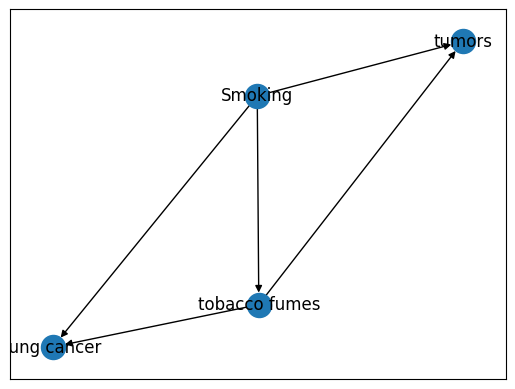

In [21]:
# text = 'Smoking is a major cause of lung cancer. Tobacco smoke contains harmful substances that can lead to tumor formation in the lungs. Quitting smoking reduces the risk of lung cancer and improves overall health.'
text = 'Smoking involves inhaling tobacco fumes; it can cause lung cancer and tumors.'
text_title = 'Smoking'
causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=True, optimize_found_entities=False, use_text_in_entity_optimization=True, verbose=True)

Text:
Smoking involves inhaling tobacco fumes; it can cause lung cancer and tumors.
--
<Answer><Entity>Smoking</Entity><Entity>tobacco fumes</Entity><Entity>lung cancer</Entity><Entity>tumors</Entity></Answer>
Entities: (4)
['Smoking', 'tobacco fumes', 'lung cancer', 'tumors']
--
Optimized Entities: (3)
['Smoking', 'tobacco fumes', 'lung cancer']
--
0 = Smoking, 1 = tobacco fumes
(('Smoking', 'tobacco fumes'), 'Step 1: Understand the text\n\nThe text states that "Smoking involves inhaling tobacco fumes" and "it can cause lung cancer and tumors." This implies that smoking is the action of inhaling tobacco fumes, and smoking can lead to lung cancer and tumors.\n\nStep 2: Analyze the entities\n\nThe entities mentioned are "Smoking" and "tobacco fumes."\n\nStep 3: Identify the cause-and-effect relationship\n\nBased on the information provided, it is more likely that the cause-and-effect relationship is:\n\nA. "Smoking" causes "tobacco fumes"\n\nThis is because smoking involves inhaling tob

(['tobacco fumes', 'Smoking', 'lung cancer'],
 [('Smoking', 'tobacco fumes'),
  ('Smoking', 'lung cancer'),
  ('tobacco fumes', 'lung cancer')])

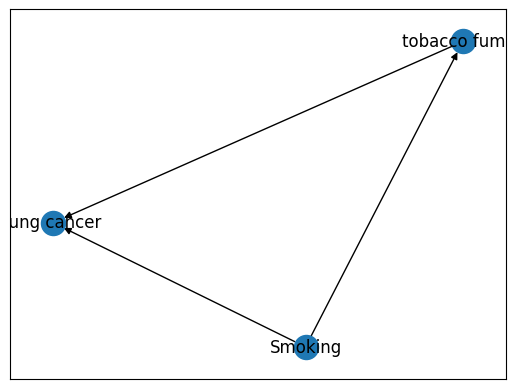

In [20]:
# text = 'Smoking is a major cause of lung cancer. Tobacco smoke contains harmful substances that can lead to tumor formation in the lungs. Quitting smoking reduces the risk of lung cancer and improves overall health.'
text = 'Smoking involves inhaling tobacco fumes; it can cause lung cancer and tumors.'
text_title = 'Smoking'
causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=True, optimize_found_entities=True, use_text_in_entity_optimization=True, verbose=True)

# Benchmarks

## Evaluation Metrics

for benchmark graphs (without NER step? directly with correct nodes)

Precision is defined by: _Pr = tp / (tp + fp)_ and directly denotes the total classification accuracy given a confidence threshold. \
On the other hand, Recall is defined by: _Re = tp / (tp + fn)_ and denotes misclassification given a threshold

### Structural Hamming Distance

In [175]:
!pip install cdt

     ---------------------------------------- 0.0/921.1 kB ? eta -:--:--
     - ----------------------------------- 41.0/921.1 kB 960.0 kB/s eta 0:00:01
     ----- -------------------------------- 122.9/921.1 kB 1.4 MB/s eta 0:00:01
     -------- ----------------------------- 194.6/921.1 kB 1.5 MB/s eta 0:00:01
     ---------- --------------------------- 256.0/921.1 kB 1.3 MB/s eta 0:00:01
     -------------- ----------------------- 358.4/921.1 kB 1.6 MB/s eta 0:00:01
     ------------------ ------------------- 450.6/921.1 kB 1.7 MB/s eta 0:00:01
     ---------------------- --------------- 553.0/921.1 kB 1.7 MB/s eta 0:00:01
     -------------------------- ----------- 634.9/921.1 kB 1.7 MB/s eta 0:00:01
     ----------------------------- -------- 716.8/921.1 kB 1.7 MB/s eta 0:00:01
     ---------------------------------- --- 829.4/921.1 kB 1.8 MB/s eta 0:00:01
     -------------------------------------  911.4/921.1 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 921

In [19]:
def plot_causal_graph(nodes, edges, title):

    if not nodes:
        return None
    
    # Create a graph
    G = nx.DiGraph()

    # Add nodes
    for node in nodes:
        G.add_node(node)

    # Add edges
    for e1, e2 in edges:
        G.add_edge(e1, e2)

    # Plot the graph
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos, arrows=True)
    nx.draw_networkx_labels(G, pos)
    #add title to graph
    plt.title(title)

In [20]:
def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

In [21]:
from cdt.metrics import SHD, precision_recall
from numpy.random import randint

def benchmark_evaluation(benchmark_title, ground_truth_nodes, ground_truth_edges, SHD_double_for_anticausal=True, plot_graphs=True, verbose=False):

    if ground_truth_nodes is None or ground_truth_edges is None:
        print("Ground truth nodes or edges are None.")
        return None, None, None
    
    nodes, prediction_edges, cycles = causal_discovery_pipeline(f'{benchmark_title} - Prediction', '', entities=ground_truth_nodes, use_text_in_causal_discovery=False, use_LLM_pretrained_knowledge_in_causal_discovery=False, reverse_edge_for_variable_check=False, optimize_found_entities=False, use_text_in_entity_optimization=False, search_cycles=True, plot_graphs=plot_graphs, plot_interactive_graph=False, verbose=verbose)
    print(prediction_edges)
    if plot_graphs:
        plot_causal_graph(ground_truth_nodes, ground_truth_edges, title=f'{benchmark_title} - Ground Truth')

    ground_truth_graph = nx.DiGraph()
    ground_truth_graph.add_nodes_from(nodes)
    ground_truth_graph.add_edges_from(ground_truth_edges)

    prediction_graph = nx.DiGraph()
    prediction_graph.add_nodes_from(nodes)
    prediction_graph.add_edges_from(prediction_edges)

    shd = SHD(ground_truth_graph, prediction_graph, double_for_anticausal=SHD_double_for_anticausal)

    if verbose:
        print(f'SHD = {shd}')

    aupr, curve = precision_recall(ground_truth_graph, prediction_graph)

    if plot_graphs:
        # Plot the precision-recall curve as a line plot
        precision_values = [point[0] for point in curve]
        recall_values = [point[1] for point in curve]
        plt.figure()
        plt.plot(recall_values, precision_values, marker='o', linestyle='-')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Prediction Precision-Recall Curve')
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.grid(True)

        # ideal line
        plt.plot([1.0, 1.0, 0.0], [0.0, 1.0, 1.0], linestyle='--')

        plt.show()


    if verbose:
        print(f"Area under the precision-recall curve: {aupr}")

    return shd, aupr, curve, prediction_edges, cycles

Detecting 1 CUDA device(s).


In [22]:
def precision_recall_curve_plot(curves, titles):
    fig = go.Figure()

    for i, curve_point in enumerate(curves):
        precision_values = [point[0] for point in curve_point]
        recall_values = [point[1] for point in curve_point]

        fig.add_trace(go.Scatter(
                x=recall_values,
                y=precision_values,
                text=f'F1 score = {f1_score(precision_values[1], recall_values[1]):.2f}',
                mode='lines+markers',
                name=titles[i]
            ))

    # ideal line
    fig.add_trace(go.Scatter(
                x=[0.0, 1.0, 1.0],
                y=[1.0, 1.0, 0.0],
                text='F1 score = 1.0',
                mode='lines+markers',
                name='Ideal PR line',
                line = dict(dash='dash'))
            )

    fig.update_layout(
        title='Prediction Precision-Recall Curve',
        xaxis_title='Recall',
        yaxis_title='Precision',
        xaxis=dict(range=[-0.1, 1.1]),
        yaxis=dict(categoryorder='total ascending'),
    )

    fig.show()

In [23]:
def f1_score_hist(curves, titles):
    fig = go.Figure()

    best_points = [points[1] for points in curves]
    f1s = []
    for i, (precision, recall) in enumerate(best_points):
        f1 = f1_score(precision, recall)
        f1s.append(f1)
        fig.add_trace(go.Bar(
            y=[titles[i]],
            x=[f1],
            orientation='h',
            text=f'{f1:.2f}',
            textposition='inside',
            hoverinfo='x',
            name=titles[i]
        ))

    avg = np.mean(f1s)
    fig.add_trace(go.Bar(
            y=['Average'],
            x=[avg],
            orientation='h',
            text=f'{avg:.2f}',
            textposition='inside',
            hoverinfo='x',
            name='Average'
    ))

    fig.update_layout(
        title='F1 Scores for Benchmarks',
        xaxis_title='F1 Score',
        yaxis_title='Benchmark',
        xaxis=dict(range=[0, 1.1]),
        yaxis=dict(categoryorder='total ascending'),
    )

    fig.show()

In [24]:
def shd_hist(shd_values, benchmark_titles):
    
    shds = shd_values.copy()
    titles = benchmark_titles.copy()

    shds.append(np.mean(shds))
    avg_title = 'Average'
    benchmark_titles.append(avg_title)

    sorted_shds, sorted_titles = zip(*sorted(zip(shds, titles)))

    fig = px.bar(x=sorted_titles, y=sorted_shds, title='Structural Hamming Distance for benchmarks')

    fig.update_xaxes(title_text='Benchmarks')
    fig.update_yaxes(title_text='Structural Hamming Distance')
    fig.show()

In [28]:
ground_truth_graphs = [
                     ('Asia_benchmark', ['visit to Asia', 'tubercolosis', 'lung cancer', 'bronchitis', 'dyspnoea', 'smoking', 'positive X-ray'], [('visit to Asia', 'tubercolosis'), ('smoking', 'lung cancer'), ('smoking', 'bronchitis'), ('bronchitis', 'dyspnoea'), ('lung cancer', 'dyspnoea'), ('tubercolosis', 'dyspnoea'), ('lung cancer', 'positive X-ray'), ('tubercolosis', 'positive X-ray')]),
                     ('Smoking_benchmark', ['smoking', 'tobacco fumes', 'lung cancer', 'tumors'], [('smoking', 'tobacco fumes'), ('smoking', 'lung cancer'), ('smoking', 'tumors'), ('tobacco fumes', 'lung cancer'), ('tobacco fumes', 'tumors'), ('lung cancer', 'tumors'), ('tumors', 'lung cancer')]),
                     ('Alcohol_benchmark', ['alcohol', 'liver cirrhosis', 'death'], [('alcohol', 'liver cirrhosis'), ('liver cirrhosis', 'death'), ('alcohol', 'death')]),
                     ('Cancer_benchmark', ['smoking', 'respiratory disease', 'lung cancer', 'asbestos exposure'], [('smoking', 'respiratory disease'), ('respiratory disease', 'lung cancer'), ('asbestos exposure', 'lung cancer'), ('asbestos exposure', 'respiratory disease'), ('smoking', 'lung cancer')]),
                     ('Pollution_benchmark', ['pollution', 'smoking', 'lung cancer', 'dyspnoea', 'positive X-ray'], [('smoking', 'lung cancer'), ('pollution', 'lung cancer'), ('lung cancer', 'positive X-ray'), ('lung cancer', 'dyspnoea')]),
                     ('Diabetes_benchmark', ['lack of exercise', 'body weight', 'diabetes', 'diet'], [('lack of exercise', 'body weight'), ('lack of exercise', 'diabetes'), ('body weight', 'diabetes'), ('diet', 'diabetes'), ('diet', 'body weight')]),
                     ('Obesity_benchmark', ['obesity', 'mortality', 'heart failure', 'heart defects'], [('obesity', 'mortality'), ('obesity', 'heart failure'), ('heart failure', 'mortality'), ('heart defects', 'heart failure'), ('heart defects', 'mortality')]),
                     ]

titles = []
shds = []
auprs = []
curves = []
pred_edges = []
pred_cycles = []

for title, ground_truth_nodes, ground_truth_edges in ground_truth_graphs:
   shd, aupr, curve, prediction_edges, prediction_cycles = benchmark_evaluation(title, ground_truth_nodes, ground_truth_edges, plot_graphs=False, verbose=False)
   titles.append(title)
   shds.append(shd)
   auprs.append(aupr)
   curves.append(curve)
   pred_edges.append(prediction_edges)
   pred_cycles.append(prediction_cycles)
   print(f'{title} completed:')
   print(f'    SHD                  = {shd}')
   print(f'    Ground Truth edges   = {len(ground_truth_edges)} edges')
   print(f'    Prediction edges     = {len(prediction_edges)} edges')
   print(f'    Area PAC             = {aupr}')
   print(f'    PAC point            = {curve}')
   print(f'    Cycles               = {prediction_cycles}')
   print('')

print('Benchmarks completed')

precision_recall_curve_plot(curves, titles)
f1_score_hist(curves, titles)
shd_hist(shds, titles)

Progress: 100%|██████████| 21/21 [08:52<00:00, 25.34s/it]


Cycles sorted
[('visit to Asia', 'tubercolosis'), ('tubercolosis', 'dyspnoea'), ('smoking', 'tubercolosis'), ('tubercolosis', 'positive X-ray'), ('lung cancer', 'dyspnoea'), ('smoking', 'lung cancer'), ('lung cancer', 'positive X-ray'), ('bronchitis', 'dyspnoea'), ('smoking', 'bronchitis'), ('bronchitis', 'positive X-ray'), ('smoking', 'dyspnoea'), ('smoking', 'positive X-ray'), ('lung cancer', 'bronchitis'), ('bronchitis', 'lung cancer'), ('dyspnoea', 'positive X-ray'), ('positive X-ray', 'dyspnoea')]
Asia_benchmark completed:
    SHD                  = 8
    Ground Truth edges   = 8 edges
    Prediction edges     = 16 edges
    Area PAC             = 0.75
    PAC point            = [(0.16326530612244897, 1.0), (0.5, 1.0), (1.0, 0.0)]
    Cycles               = []



Progress: 100%|██████████| 6/6 [02:02<00:00, 20.41s/it]


Cycles sorted
[('smoking', 'tobacco fumes'), ('smoking', 'lung cancer'), ('smoking', 'tumors'), ('tobacco fumes', 'lung cancer'), ('tobacco fumes', 'tumors'), ('lung cancer', 'tumors')]
Smoking_benchmark completed:
    SHD                  = 1
    Ground Truth edges   = 7 edges
    Prediction edges     = 6 edges
    Area PAC             = 0.9598214285714286
    PAC point            = [(0.4375, 1.0), (1.0, 0.8571428571428571), (1.0, 0.0)]
    Cycles               = []



Progress: 100%|██████████| 3/3 [01:05<00:00, 21.82s/it]


Cycles sorted
[('alcohol', 'liver cirrhosis'), ('alcohol', 'death'), ('liver cirrhosis', 'death')]
Alcohol_benchmark completed:
    SHD                  = 0
    Ground Truth edges   = 3 edges
    Prediction edges     = 3 edges
    Area PAC             = 1.0
    PAC point            = [(0.3333333333333333, 1.0), (1.0, 1.0), (1.0, 0.0)]
    Cycles               = []



Progress: 100%|██████████| 6/6 [02:21<00:00, 23.59s/it]


Cycles sorted
[('smoking', 'respiratory disease'), ('smoking', 'lung cancer'), ('asbestos exposure', 'respiratory disease'), ('asbestos exposure', 'lung cancer'), ('respiratory disease', 'lung cancer'), ('lung cancer', 'respiratory disease')]
Cancer_benchmark completed:
    SHD                  = 1
    Ground Truth edges   = 5 edges
    Prediction edges     = 6 edges
    Area PAC             = 0.9166666666666667
    PAC point            = [(0.3125, 1.0), (0.8333333333333334, 1.0), (1.0, 0.0)]
    Cycles               = []



Progress: 100%|██████████| 6/6 [02:14<00:00, 22.36s/it]


Cycles sorted
[('lack of exercise', 'body weight'), ('lack of exercise', 'diabetes'), ('body weight', 'diabetes'), ('diet', 'body weight'), ('diet', 'diabetes'), ('lack of exercise', 'diet'), ('diet', 'lack of exercise')]
Diabetes_benchmark completed:
    SHD                  = 2
    Ground Truth edges   = 5 edges
    Prediction edges     = 7 edges
    Area PAC             = 0.8571428571428572
    PAC point            = [(0.3125, 1.0), (0.7142857142857143, 1.0), (1.0, 0.0)]
    Cycles               = []



Progress: 100%|██████████| 6/6 [01:58<00:00, 19.71s/it]

Cycles sorted
[('obesity', 'mortality'), ('obesity', 'heart failure'), ('obesity', 'heart defects'), ('heart failure', 'mortality'), ('heart defects', 'mortality'), ('heart defects', 'heart failure')]
Obesity_benchmark completed:
    SHD                  = 1
    Ground Truth edges   = 5 edges
    Prediction edges     = 6 edges
    Area PAC             = 0.9166666666666667
    PAC point            = [(0.3125, 1.0), (0.8333333333333334, 1.0), (1.0, 0.0)]
    Cycles               = []

Benchmarks completed


In [194]:
precision_recall_curve_plot(curves, titles)
f1_score_hist(curves, titles)
shd_hist(shds, titles)

Text:

--
Skipping NER operation. Using provided entities.
--
Entities: (3)
['alcohol', 'liver cirrhosis', 'death']
--
0 = alcohol, 1 = liver cirrhosis
(('alcohol', 'liver cirrhosis'), 'Step 1: Determine if there is a temporal relationship between the entities "alcohol" and "liver cirrhosis".\n\n"Liver cirrhosis" is a condition that develops over time, often as a result of chronic liver damage. "Alcohol" is known to be a major cause of liver cirrhosis. Therefore, there is a temporal relationship between the two entities. \n\nStep 2: Evaluate the evidence for a causal relationship between "alcohol" and "liver cirrhosis".\n\nNumerous scientific studies have established a strong association between alcohol consumption and the development of liver cirrhosis. Excessive and long-term alcohol consumption is a known risk factor for liver cirrhosis.\n\nStep 3: Consider alternative explanations for the observed relationship.\n\nOne possible alternative explanation is that "liver cirrhosis" cause

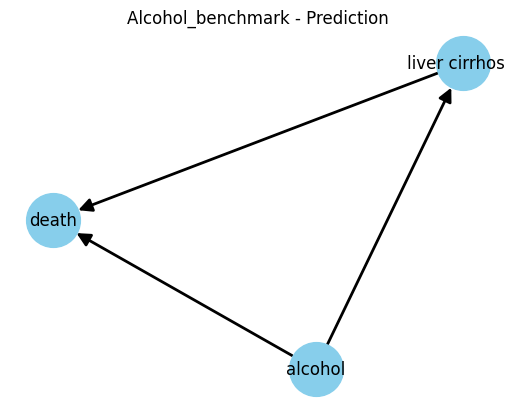

Graph is acyclic
--
alcohol -> liver cirrhosis
alcohol -> death
liver cirrhosis -> death
SHD = 0


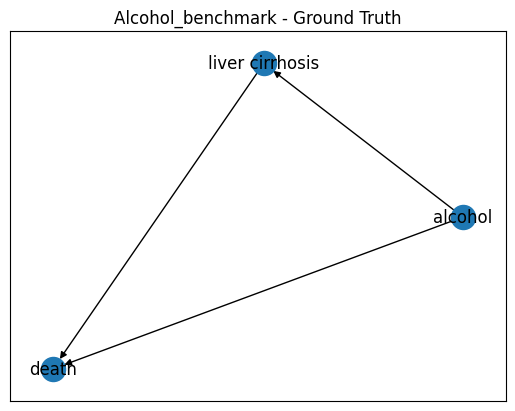

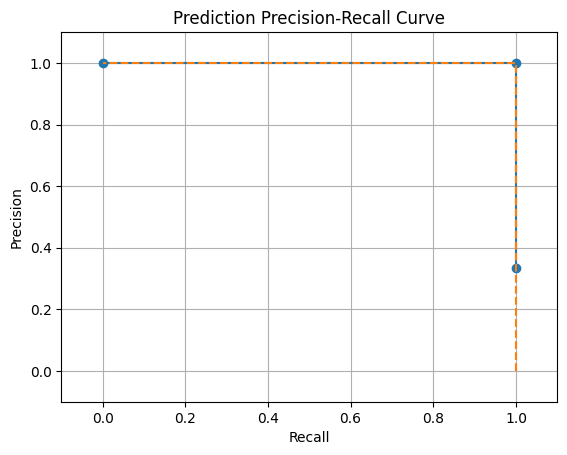

Area under the precision-recall curve: 1.0


In [54]:
ground_truth_nodes = ['alcohol', 'liver cirrhosis', 'death']
ground_truth_edges = [('alcohol', 'liver cirrhosis'), ('liver cirrhosis', 'death'), ('alcohol', 'death')]
title = 'Alcohol_benchmark'
shd, aupr, curve = benchmark_evaluation(title, ground_truth_nodes, ground_truth_edges, plot_graphs=True, verbose=True)

### Intervention Hamming Distance

In [66]:
# minimal number of interventions (edge addition/removal/flip) to turn graph_1 into graph_2

## Asia

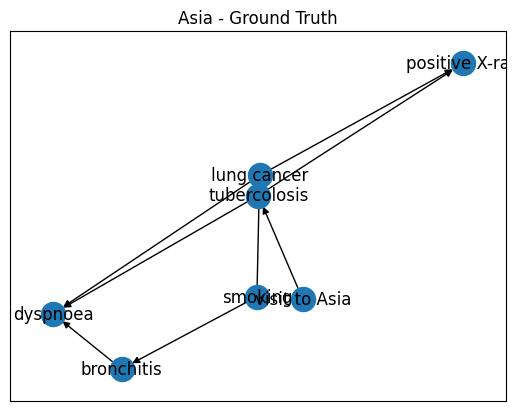

In [24]:
ground_truth_nodes = ['visit to Asia', 'tubercolosis', 'lung cancer', 'bronchitis', 'dyspnoea', 'smoking', 'positive X-ray']
ground_truth_edges = [('visit to Asia', 'tubercolosis'), ('smoking', 'lung cancer'), ('smoking', 'bronchitis'), ('bronchitis', 'dyspnoea'), ('lung cancer', 'dyspnoea'), ('tubercolosis', 'dyspnoea'), ('lung cancer', 'positive X-ray'), ('tubercolosis', 'positive X-ray')]
# plot_interactive_graph(ground_truth_nodes, ground_truth_edges, name='Asia - Ground Truth')
plot_causal_graph(ground_truth_nodes, ground_truth_edges, title='Asia - Ground Truth')

Text:
Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.
--
<Answer><Entity>Shortness-of-breath (dyspnoea)</Entity><Entity>tuberculosis</Entity><Entity>lung cancer</Entity><Entity>bronchitis</Entity><Entity>Asia</Entity><Entity>smoking</Entity></Answer>
Entities: (6)
['Shortness-of-breath (dyspnoea)', 'tuberculosis', 'lung cancer', 'bronchitis', 'Asia', 'smoking']
--
Optimized Entities: (4)
['Shortness-of-breath (dyspnoea)', 'tuberculosis', 'bronchitis', 'smoking']
--
0 = Shortness-of-breath (dyspnoea), 1 = tuberculosis
(('Shortness-of-breath (dyspnoea)', 'tuberculosis'), 'To determine the cause-and-effect relationship betwee

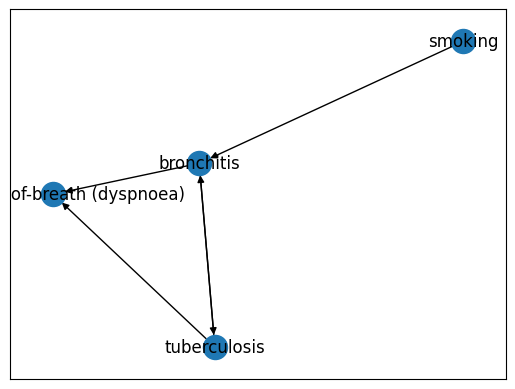

In [29]:
import time

text = 'Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.'
text_title = f'Asia_{time.time().as_integer_ratio()[0]}'
nodes, edges = causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=False, reverse_edge_for_variable_check=True, optimize_found_entities=True, use_text_in_entity_optimization=False, verbose=True)

Text:
Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.
--
<Answer><Entity>Shortness-of-breath</Entity><Entity>dyspnoea</Entity><Entity>tuberculosis</Entity><Entity>lung cancer</Entity><Entity>bronchitis</Entity><Entity>Asia</Entity><Entity>smoking</Entity><Entity>risk factor</Entity><Entity>chest X-ray</Entity></Answer>
Entities: (9)
['Shortness-of-breath', 'dyspnoea', 'tuberculosis', 'lung cancer', 'bronchitis', 'Asia', 'smoking', 'risk factor', 'chest X-ray']
--
Optimized Entities: (7)
['Shortness-of-breath', 'tuberculosis', 'lung cancer', 'bronchitis', 'smoking', 'risk factor', 'chest X-ray']
--
0 = Shortness-of-breath, 

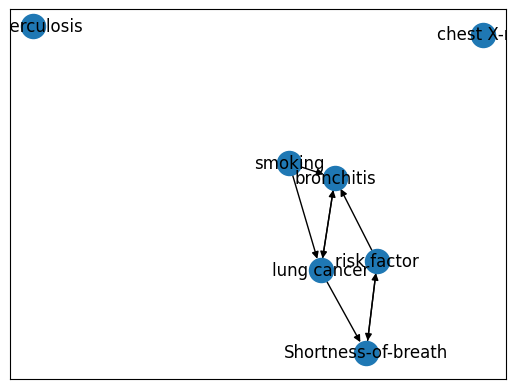

In [118]:
import time

text = 'Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.'
text_title = f'Asia_{time.time().as_integer_ratio()[0]}'
nodes, edges = causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=False, reverse_edge_for_variable_check=True, optimize_found_entities=True, use_text_in_entity_optimization=False, verbose=True)

## Alcohol

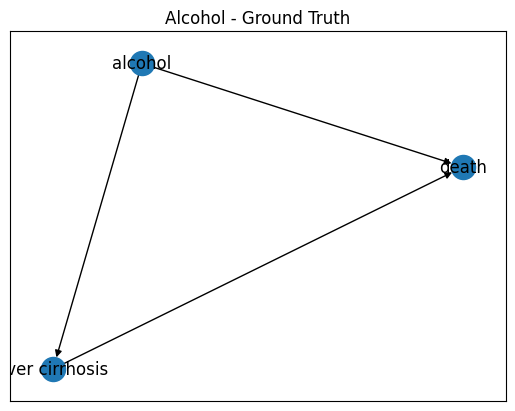

In [28]:
nodes = ['alcohol', 'liver cirrhosis', 'death']
edges = [('alcohol', 'liver cirrhosis'), ('liver cirrhosis', 'death'), ('alcohol', 'death')]
plot_causal_graph(nodes, edges, title='Alcohol - Ground Truth')

Text:
Excessive alcohol consumption can lead to liver cirrhosis, which can ultimately result in death.
--
<Answer><Entity>alcohol consumption</Entity><Entity>liver cirrhosis</Entity><Entity>death</Entity></Answer>
Entities: (3)
['alcohol consumption', 'liver cirrhosis', 'death']
--
Optimized Entities: (3)
['alcohol consumption', 'liver cirrhosis', 'death']
--
0 = alcohol consumption, 1 = liver cirrhosis
(('alcohol consumption', 'liver cirrhosis'), 'Step 1: Identify the direction of the causal relationship mentioned in the text. The text states that "Excessive alcohol consumption can lead to liver cirrhosis." This suggests that "alcohol consumption" is the cause and "liver cirrhosis" is the effect.\n\nStep 2: Determine if there is any evidence or knowledge that supports the reverse causal relationship ("liver cirrhosis" causing "alcohol consumption"). Based on the given text, there is no information to suggest that "liver cirrhosis" causes "alcohol consumption."\n\nStep 3: Consider the 

({'alcohol consumption', 'death', 'liver cirrhosis'},
 {('alcohol consumption', 'death'),
  ('alcohol consumption', 'liver cirrhosis'),
  ('liver cirrhosis', 'death')})

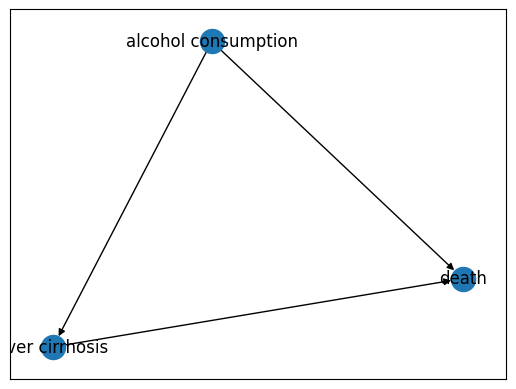

In [24]:
text = 'Excessive alcohol consumption can lead to liver cirrhosis, which can ultimately result in death.'
text_title = 'Alcohol'
causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=True, optimize_found_entities=True, use_text_in_entity_optimization=True, verbose=True)

## Cancer

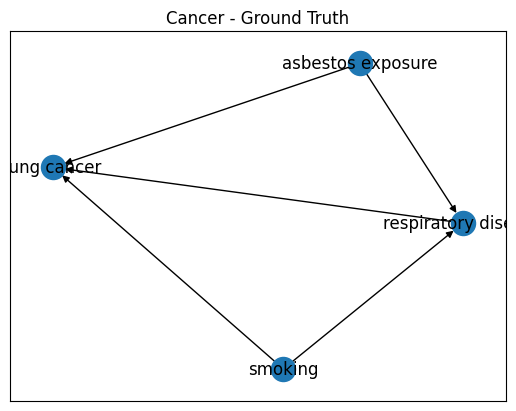

In [25]:
nodes = ['smoking', 'respiratory disease', 'lung cancer', 'asbestos exposure']
edges = [('smoking', 'respiratory disease'), ('respiratory disease', 'lung cancer'), ('asbestos exposure', 'lung cancer'), ('asbestos exposure', 'respiratory disease'), ('smoking', 'lung cancer')]
plot_causal_graph(nodes, edges, title='Cancer - Ground Truth')

In [ ]:
text = 'Long-term asbestos exposure and smoking are significant risk factors for developing respiratory diseases, including lung cancer.'
text_title = 'Cancer'
causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=True, optimize_found_entities=True, use_text_in_entity_optimization=True, verbose=True)

Text:
Long-term asbestos exposure and smoking are significant risk factors for developing respiratory diseases, including lung cancer.
--
<Answer><Entity>asbestos exposure</Entity><Entity>smoking</Entity><Entity>respiratory diseases</Entity><Entity>lung cancer</Entity></Answer>
Entities: (4)
['asbestos exposure', 'smoking', 'respiratory diseases', 'lung cancer']
--
Optimized Entities: (4)
['asbestos exposure', 'smoking', 'respiratory diseases', 'lung cancer']
--
0 = asbestos exposure, 1 = smoking
(('asbestos exposure', 'smoking'), 'Step 1: Understand the statement\nThe given text states that long-term asbestos exposure and smoking are significant risk factors for developing respiratory diseases, including lung cancer.\n\nStep 2: Identify the causal relationships\nIn this case, we have two potential cause-and-effect relationships to consider:\n\nA. "asbestos exposure" causes "smoking"\nB. "smoking" causes "asbestos exposure"\n\nStep 3: Evaluate the plausibility of each relationship\n\nN

({'asbestos exposure', 'lung cancer', 'respiratory diseases', 'smoking'},
 {('asbestos exposure', 'lung cancer'),
  ('asbestos exposure', 'respiratory diseases'),
  ('asbestos exposure', 'smoking'),
  ('lung cancer', 'respiratory diseases'),
  ('respiratory diseases', 'lung cancer'),
  ('smoking', 'asbestos exposure'),
  ('smoking', 'lung cancer'),
  ('smoking', 'respiratory diseases')})

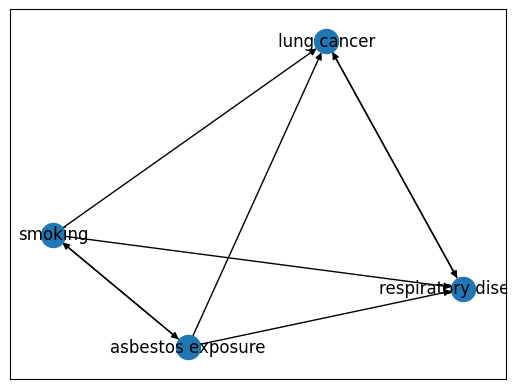

In [27]:
text = 'Long-term asbestos exposure and smoking are significant risk factors for developing respiratory diseases, including lung cancer.'
text_title = 'Cancer'
causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=True, optimize_found_entities=True, use_text_in_entity_optimization=True, verbose=True)

## Diabetes

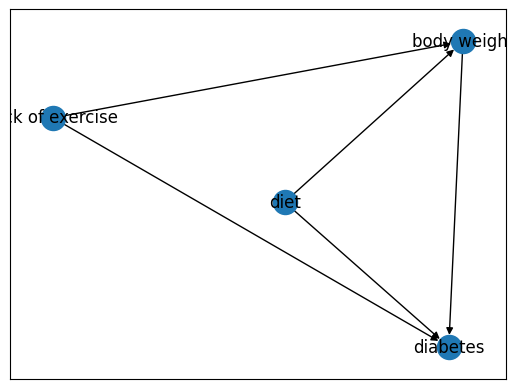

In [29]:
nodes = ['lack of exercise', 'body weight', 'diabetes', 'diet']
edges = [('lack of exercise', 'body weight'), ('lack of exercise', 'diabetes'), ('body weight', 'diabetes'), ('diet', 'diabetes'), ('diet', 'body weight')]
plot_causal_graph(nodes, edges, title='Diabetes - Ground Truth')

Text:
Unhealthy diet, lack of exercise, and excessive body weight can contribute to the development of diabetes.
--
<Answer><Entity>unhealthy diet</Entity><Entity>lack of exercise</Entity><Entity>excessive body weight</Entity><Entity>diabetes</Entity></Answer>
Entities: (4)
['unhealthy diet', 'lack of exercise', 'excessive body weight', 'diabetes']
--
Optimized Entities: (4)
['unhealthy diet', 'lack of exercise', 'excessive body weight', 'diabetes']
--
0 = unhealthy diet, 1 = lack of exercise
(('unhealthy diet', 'lack of exercise'), 'Step 1: Identify the cause and effect entities:\n- Cause entity: "unhealthy diet"\n- Effect entity: "lack of exercise"\n\nStep 2: Determine the causal relationship:\nTo determine the causal relationship between "unhealthy diet" and "lack of exercise", we need to analyze the information provided in the medical text and our pre-trained knowledge.\n\nThe text states that "unhealthy diet, lack of exercise, and excessive body weight can contribute to the develo

({'diabetes', 'excessive body weight', 'lack of exercise', 'unhealthy diet'},
 {('excessive body weight', 'diabetes'),
  ('lack of exercise', 'diabetes'),
  ('lack of exercise', 'excessive body weight'),
  ('unhealthy diet', 'diabetes'),
  ('unhealthy diet', 'excessive body weight')})

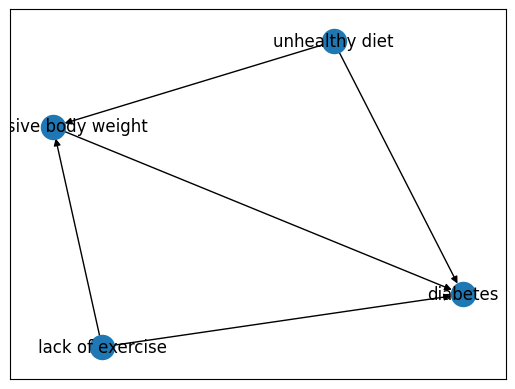

In [33]:
text = 'Unhealthy diet, lack of exercise, and excessive body weight can contribute to the development of diabetes.'
text_title = 'Diabetes'
causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=True, optimize_found_entities=True, use_text_in_entity_optimization=True, verbose=True)

In [79]:
text = 'Unhealthy diet, lack of exercise, and excessive body weight can contribute to the development of diabetes.'
text_title = 'Diabetes'
gpt_ner(text)
# causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=True, optimize_found_entities=True, use_text_in_entity_optimization=True, verbose=True)

<Answer><Entity>diabetes</Entity></Answer>


['diabetes']

## Obesity

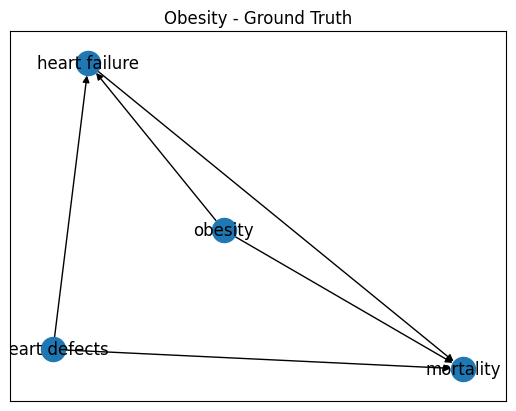

In [26]:
nodes = ['obesity', 'mortality', 'heart failure', 'heart defects']
edges = [('obesity', 'mortality'), ('obesity', 'heart failure'), ('heart failure', 'mortality'), ('heart defects', 'heart failure'), ('heart defects', 'mortality')]
plot_causal_graph(nodes, edges, title='Obesity - Ground Truth')

Text:
Obesity and heart defects can cause both mortality and heart failures, which can itself lead to mortality.
--
<Answer><Entity>Obesity</Entity><Entity>heart defects</Entity><Entity>mortality</Entity><Entity>heart failures</Entity></Answer>
Entities: (4)
['Obesity', 'heart defects', 'mortality', 'heart failures']
--
0 = Obesity, 1 = heart defects
(('Obesity', 'heart defects'), 'Step 1: Identify the causal relationships mentioned in the given text.\n\nThe text states that both obesity and heart defects can cause mortality and heart failures, which can in turn lead to mortality. Therefore, there are two possible causal relationships mentioned:\n1. Obesity causes heart defects, which in turn lead to mortality and heart failures.\n2. Heart defects cause obesity, which in turn lead to mortality and heart failures.\n\nStep 2: Analyze the plausibility of each causal relationship.\n\nA. "Obesity" causes "heart defects":\nThis causal relationship is plausible because obesity is known to hav

({'Obesity', 'heart defects', 'heart failures', 'mortality'},
 {('Obesity', 'heart failures'),
  ('Obesity', 'mortality'),
  ('heart defects', 'mortality'),
  ('heart failures', 'mortality')})

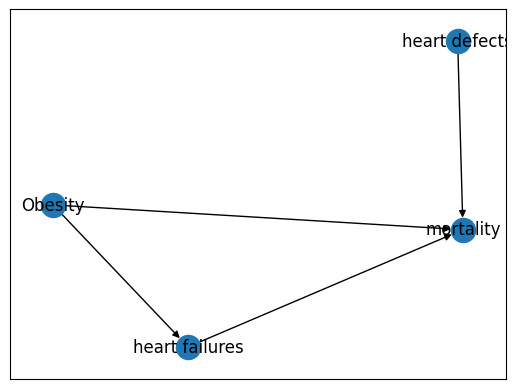

In [87]:
text = 'Obesity is associated with an increased risk of mortality, mainly due to its connection to heart failure and heart defects.'
# text = 'Obesity can cause heart failure, which can lead to mortality. Heart defects can also cause heart failure, which can also lead to mortality. Both heart defects and obesity can lead to mortality.'
text = 'Obesity and heart defects can cause a heart failure, which can lead to mortality. Both heart defects and obesity can also lead to mortality.'
text = 'Obesity and heart defects can cause both mortality and heart failures, which can itself lead to mortality.'
text_title = 'Obesity'
causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=True, optimize_found_entities=False, use_text_in_entity_optimization=True, verbose=True)

Text:
Obesity is associated with an increased risk of mortality, mainly due to its connection to heart failure and heart defects.
--
<Answer><Entity>Obesity</Entity><Entity>mortality</Entity><Entity>heart failure</Entity><Entity>heart defects</Entity></Answer>
Entities: (4)
['Obesity', 'mortality', 'heart failure', 'heart defects']
--
0 = Obesity, 1 = mortality
(('Obesity', 'mortality'), 'Step 1: Identify the directionality of the relationship.\n\nThe medical text states that "Obesity is associated with an increased risk of mortality." This suggests that there is a relationship between obesity and mortality, but it does not specify the direction of the causality.\n\nStep 2: Analyze the information provided.\n\nThe text states that obesity is associated with an increased risk of mortality, mainly due to its connection to heart failure and heart defects. This suggests that obesity might contribute to mortality by increasing the likelihood of heart failure and heart defects.\n\nStep 3: Co

({'Obesity', 'heart defects', 'heart failure', 'mortality'},
 {('Obesity', 'heart defects'),
  ('Obesity', 'heart failure'),
  ('Obesity', 'mortality'),
  ('heart defects', 'heart failure'),
  ('heart defects', 'mortality'),
  ('heart failure', 'heart defects'),
  ('heart failure', 'mortality'),
  ('mortality', 'heart failure')})

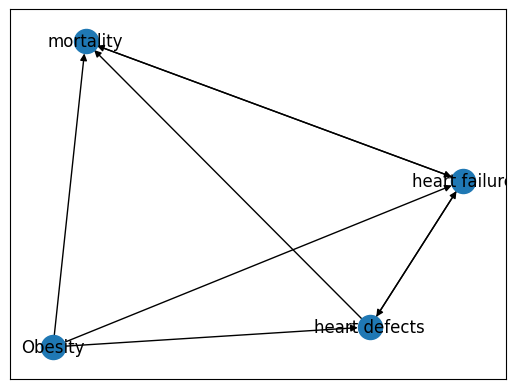

In [38]:
text = 'Obesity is associated with an increased risk of mortality, mainly due to its connection to heart failure and heart defects.'
text = 'Obesity can cause heart failure, which can lead to mortality. Heart defects can also cause heart failure, which can also lead to mortality. Both heart defects and obesity can lead to mortality.'
text_title = 'Obesity'
causal_discovery_pipeline(text_title, text, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=False, optimize_found_entities=False, use_text_in_entity_optimization=True, verbose=True)

# PubMed Causal Discovery

In [20]:
df = pd.read_csv('../data/pubmed_data.csv') 

text = df['abstract'][0]
text

'Retinal ischemia/reperfusion (I/R) injury is a common pathological process responsible for cellular damage in glaucoma, diabetic retinopathy and hypertensive retinopathy. Metformin is a biguanide drug that exerts strong effects on multiple diseases. This study aims to evaluate the protective effect of metformin against retinal I/R injury and its underlying mechanism. I/R induced reduction in retina thickness and cell number in ganglion cell layer, and metformin alleviated I/R-induced retinal injury. Both retinal I/R and simulated ischemia/reperfusion (SIR) in R28\u202fcells down-regulated expression of mitochondrial fusion protein Mfn2 and OPA1, which led to mitochondrial fission. Metformin also alleviated damage in R28\u202fcells, and reversed the alteration in Mfn2 and OPA1, mitochondrial fission and mitochondrial membrane potential (MMP) disruption-induced by I/R or SIR as well. Intriguingly, inhibition of AMPK by compound C or siRNA prevented metformin-mediated up-regulation of Mf

In [23]:
sample = df['abstract'].sample().values[0]
print(f'{sample}\n')

causal_discovery_pipeline('test', sample, use_text_in_causal_discovery=True, use_LLM_pretrained_knowledge_in_causal_discovery=True, reverse_edge_for_variable_check=False, optimize_found_entities=True, use_text_in_entity_optimization=True, verbose=True)

This study aimed to identify the effect of electroacupuncture (EA) treatment on post-stroke depression (PSD) and explore whether cannabinoid receptor 1 (CB1R)-mediated mitochondrial biogenesis accounts for the treatment effect of EA.The PSD mouse model was induced by a consecutive 14-day chronic unpredictable stress operation after 7 days of recovery from the bilateral common carotid artery occlusion surgery. Either EA treatment or sham stimulation was performed for 14 consecutive days from Day 7 after the BCCAO operation. Subjects' PSD-like behaviors were tested via open field test, sucrose preference test, novelty suppressed feeding test, tail suspension test, and forced swim test, and subjects' cognitive function was examined using Y-maze and novelty object recognition test. In addition, the levels of CB1R, mitochondrial biogenesis-related proteins (nuclear transcription factor 1, NRF1; mitochondrial transcription factor A, TFAM), proteins related to mitochondrial function (Cytochro

(('proteins related to mitochondrial function (Cytochrome C, Cyto C; AIF, COX IV)', 'mitochondrial DNA'), 'To determine the causal relationship between "proteins related to mitochondrial function" and "mitochondrial DNA", we need to analyze the information provided in the medical text.\n\n1. Firstly, it states that electroacupuncture (EA) treatment improved mitochondrial biogenesis. This suggests that EA treatment has a positive effect on the production of new mitochondria.\n\n2. The text also mentions that EA treatment upregulated CB1R, NRF1, and TFAM expressions. These proteins are related to mitochondrial biogenesis.\n\n3. However, when CB1R antagonists were given before EA treatment, the antidepressant-like effects of EA were blocked. This indicates that CB1R activation is necessary for the beneficial effects of EA.\n\n4. The text does not explicitly state a direct causal relationship between the proteins related to mitochondrial function (Cytochrome C, AIF, COX IV) and mitochondri

# NOTES

For example, if we wanted to elicit a prediction for the direction of an edge between variables with metadata µi: “lung cancer”, µj : “cigarette smoking”, and causation verb verb_k: “causes” we would use the following prompt:

_Among these two options which one is the most likely true: \
(A) lung cancer causes cigarette smoking \
(B) cigarette smoking causes lung cancer \
The answer is:_

We then compute the log probability of the responses (A) and (B), and use the softmax to obtain a probability distribution
over the directions of the edge (Kadavath et al., 2022). Since we rely on scoring, instead of generation, the output of the
LLM-expert is deterministic given a fixed prompt. To foster randomness in the LLM-expert outputs, we randomly draw
verb_k from the following verbs of causation: provokes, triggers, causes, leads to, induces, results in, brings about, yields,
generates, initiates, produces, stimulates, instigates, fosters, engenders, promotes, catalyzes, gives rise to, spurs, and sparks.

introducing variation in the verbs used to express causality in your list of options could potentially lead to more diverse and coherent answers. GPT-3, being deterministic given the same prompt, can sometimes produce more interesting and nuanced responses when provided with varied input. By incorporating synonyms for "causes" in your options, you encourage the model to explore different linguistic expressions of causality, which can lead to more coherent and contextually appropriate responses. using synonyms like "provokes", "triggers", "results in", and others can help in generating more diverse and contextually relevant cause-and-effect relationships. It can potentially lead to a richer exploration of the underlying causal connections between the entities you're asking about.

verbs = ['provokes', 'triggers', 'causes', 'leads to', 'induces', 'results in', 'brings about', 'yields',
'generates', 'initiates', 'produces', 'stimulates', 'instigates', 'fosters', 'engenders', 'promotes', 'catalyzes', 'gives rise to', 'spurs', 'sparks']






1. eventually add new benchmarks in code ('Asia'-like graphs from '_Causal Discovery with Language Models as Imperfect Experts_' = https://www.bnlearn.com/bnrepository/ and DAGs in '_progetto diploma/Ground Truth DAGs for medical benchmark.PNG_' from '_Can Large Language Models Build Causal Graphs?_' )
2. update docs with benchmarks
3. update docs with DFS acyclicity check
4. update causal query with random verbs (single or multi query for each pair of variables, then find edge with best score ??)
5. ask what to do in case of a cycle (e.g., extract edges that cause it and requery LLM for new edges ??)




https://arxiv.org/ftp/arxiv/papers/1302/1302.4972.pdf - Causal inference and causal explanation with background 
knowledge


# TODO - update docs with benchmarks


1. benchmarks
    - pipeline completa (con NER) solo per grafi che hanno un testo, tutti gli altri skippano step di NER e fanno direttamente Causal Discovery con le entità vere/finali
    - precision, recall, f1, SHD, IHM dei risultati sulla Ground Truth 

2. sinonimi
    - capire se tenere step ottimizzazione entità
    - nel caso step è tenuto, associare sinonimi tra loro

3. ciclo
    - testo contraffatto per generare ciclo
    - ~~evidenziare parte di grafo (nodi e archi) che lo costituiscono~~
    

    - DFS/networkX per controllo se c'è ciclo, nel caso rimozione di un arco (pensare a quale:  se 'A --> B --> C --> D --> A'  possibile rimuovere "l'ultimo" arco, D --> A) e ripetere finche grafo diventa aciclico

4. grafo interattivo, con hover/click su arco mostra parte di testo che motiva quell'arco

5. opzione per forzare GPT a basarsi solo sul testo e non su sue conoscenze pre-trained

# Questions

1. What to do in case of a cyclic graph ? ()
2. Evalutation on benchmark ? \
     a. handle cases of graphs with different nodes, or nodes with different names \
     b. eiter _**Structural Hamming Distance**_ (differences in missing or reversed edges) or _**Structural Intervention Distance**_ (number of manipulations to turn **graph_1** into **graph_2**)
3. Benchmarks without the NER step (would solve problem 2.a of nodes with different names) ? Or with the NER step on a hand-written/generated text starting from the entities and the edges of the GT?
4. Random verbs (e.g. 'cause'/'may lead to'/'provokes'/...) in causal discovery query to gpt? 
5. In the docs, is it best to move the causality and graph definitions at the very beginning (or at the beginning of the causal analysis chapter)?
6. In the docs, is it best to move all the python code snippets in an Appendix section and add references in the text?

# GPT Prompt engineering for devs
https://www.deeplearning.ai/short-courses/chatgpt-prompt-engineering-for-developers/

https://artificialcorner.com/openai-and-andrew-ng-just-released-a-free-chatgpt-prompt-engineering-course-b0884c03e946

https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api

## PRINCIPLE 1 : Write clear and specific instructions

- use delimiters (brackets, xml tags, quotes)
- ask for structured output
- check whether conditions are satisfied; check assumptions required to do the task (e.g.: summarize text instructions into a series of steps, otherwise write 'No steps provided')
- Few-shot prompting: give successful examples of completing tasks, then ask the model to perform the task (e.g.: \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;''' \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Answer in a consistent style: \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<**child**>Teach me about patience \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<**grandparent**>: The river that carves the deepest valley flows from a modest spring, .... \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<**child**>Teach me about resilience \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;''' \
    )

## PRINCIPLE 2 : Give the model time to "think"

- request a chain or series of relevent reasoning before the model provides the final answer
- instruct the model to work out its own solution before rushing to conclusions (if the model has to check if a provided solution is correct, ask it to come up with one of his own and compare it with the provided one)

## LIMITATIONS

1. **Hallucinations** \
Even though the model has been exposed to vast amounts of textual knowledge during its training process, it has not perfectly memorized the information it has seen: this may bring the model to try answering questions about obscure topics and can make things up that sound plausible but are not actually true, known as hallucinations (e.g.: asking the model to describe a non-existing product of a real company) \
==> **To reduce hallucinations**, ask the model to find relevant information, then answer the question based on the relevant information found (try tracing the answer back to the source document).



## ITERATIVE PROMPT CRAFTING
1. try out an idea
2. implementation
3. see results
4. error analysis

In general:
- clarify instructions
- give more time to think
- refine prompts with examples

## SUMMARIZING

- word/sentence(/character) limit
- focus on particular aspects (e.g.: from an online review, focus on product quality and cost/shipment and delivery)
- **extract** (extracts info from text) vs. **summarize** (summaries may include topics that are not related to the topics of focus) with defined focus


## INFERRING

Analysis on text given as input: extracting names, labels, sentiment analysis,... . \
In traditional ML workflow, this is done by collecting dataset, training and deploy a model (a separate model for each application: NER, classification, ...); LLMs give a large speed up in application development, by allowing devs to write a prompt and generate results right away for many different tasks.

E.g.: detecting if a customer is angry in his review (to then make customer support contact him) is achievable with supervised learning but would require a large dataset to train and deploy a model; with LLMs this can be done with a simple (yet sufficiently correct) prompt. \

**MULTIPLE TASKS AT ONCE**: \
~~~
prompt = f"""
Identify the following items from the review text: 
- Sentiment (positive or negative)
- Is the reviewer expressing anger? (true or false)
- Item purchased by reviewer
- Company that made the item

The review is delimited with triple backticks. \
Format your response as a JSON object with \
"Sentiment", "Anger", "Item" and "Brand" as the keys.
If the information isn't present, use "unknown" \
as the value.
Make your response as short as possible.
Format the Anger value as a boolean.

Review text: '''{lamp_review}'''
"""
~~~

Infer topics of given articles (e.g.: USA, federal government, NASA, space exploration)


In [33]:
x = '''{
  "nasa": 1,
  "local government": 0,
  "engineering": 0,
  "employee satisfaction": 1,
  "federal government": 1
}'''
import json
x = json.loads(x)
x

{'nasa': 1,
 'local government': 0,
 'engineering': 0,
 'employee satisfaction': 1,
 'federal government': 1}

## EXPANDING

taking a small amount of input data (set of instructions or a list of topics) and generate longer pieces of text. \

**temperature** is the degree of exploration or randomness of the model's output. With temperature=**0**, the LLM will choose only the next most likely word; with higher temperatures, the LLM will choose with a higher chance one of the less likely words. \
E.g.:   With  "_My favorite food is_" the next most likely words are with 53% chance _pizza_, 30% chance _sushi_ and 5% chance _tacos_; \
with temp=0, the LLM will ALWAYS choose pizza; with higher temperature, it chooses with a higher chance pizza and tacos.

## CHAT WORKFLOW

**system**: overall instruction, sets behaviour and persona of the model, high level instruction for the conversation
**assistant**: the model responses
**user**: the final user


every request is standalone; to make the model "remember" older conversations (like for building a chatbot), the request must contain all the necessary context information (in the form of _system_, _assistant_ and _user_ messages)
